In [139]:
import pandas as pd

# URLs for OICA vehicles data (production and sales by country & type)
# Hosted CSVs via GitHub (jhelvy/oica dataset)
URL_PRODUCTION = "https://raw.githubusercontent.com/jhelvy/oica/main/data-raw/production.csv"
URL_SALES = "https://raw.githubusercontent.com/jhelvy/oica/main/data-raw/sales_country.csv"

# Load the datasets
production_df = pd.read_csv(URL_PRODUCTION)
sales_df = pd.read_csv(URL_SALES)

# Filter for commercial vehicles only (type == 'cv')
prod_cv = production_df[production_df['type'] == 'cv'].copy()
sales_cv = sales_df[sales_df['type'] == 'cv'].copy()

# Define our target countries
target_countries = [
    "India", "Japan", "Thailand",
    "South Africa", "United Arab Emirates", "Brazil", "Mexico", "Argentina"
]

# Combine Latin America region countries: Brazil, Mexico, Argentina
# (You can adjust this set as needed.)
latam_countries = ["Brazil", "Mexico", "Argentina"]

# Filter production & sales
prod_cv = prod_cv[prod_cv['country'].isin(target_countries)]
sales_cv = sales_cv[sales_cv['country'].isin(target_countries)]

# Summarize annual totals
prod_summary = prod_cv.pivot_table(
    index="year", columns="country", values="n", aggfunc="sum"
).reset_index()

sales_summary = sales_cv.pivot_table(
    index="year", columns="country", values="n", aggfunc="sum"
).reset_index()

# Show result
#print("=== Annual Commercial Vehicle Production ===")
#print(prod_summary)

print("\n=== Annual Commercial Vehicle Sales ===")
print(sales_summary)

# Save to CSV
prod_summary.to_csv("annual_commercial_vehicle_production.csv", index=False)
sales_summary.to_csv("annual_commercial_vehicle_sales.csv", index=False)

print("\nSaved CSV files: 'annual_commercial_vehicle_sales.csv'")



=== Annual Commercial Vehicle Sales ===
country  year  Argentina    Brazil      India      Japan    Mexico  \
0        2005   112042.0  274822.0   333592.0  1103552.0  454498.0   
1        2006   124182.0  294791.0   439519.0  1127202.0  503089.0   
2        2007   142696.0  377010.0   481909.0   983692.0  509425.0   
3        2008   159231.0  479050.0   437657.0   897967.0  484719.0   
4        2009   113911.0  497378.0   449391.0   704023.0  336631.0   
5        2010   175813.0  658524.0   653193.0   752967.0  344606.0   
6        2011   209497.0  731601.0   777424.0   701188.0  344679.0   
7        2012   233661.0  686848.0   813589.0   797388.0  375241.0   
8        2013   279538.0  726587.0   687323.0   813231.0  402325.0   
9        2014   181152.0  703325.0   606269.0   863297.0  431055.0   
10       2015   163069.0  445967.0   652566.0   830621.0  497280.0   
11       2016   183725.0  373599.0   702640.0   823801.0  581811.0   
12       2017   198782.0  316288.0   830346.0   8

In [140]:
import pandas as pd
import numpy as np

# Monthly seasonal weights (must sum to 1)
seasonal_weights = {
    1: 0.06,
    2: 0.06,
    3: 0.10,
    4: 0.08,
    5: 0.08,
    6: 0.09,
    7: 0.07,
    8: 0.07,
    9: 0.09,
    10: 0.12,
    11: 0.10,
    12: 0.08
}

print("Total weight:", sum(seasonal_weights.values()))


Total weight: 1.0


In [141]:
# Load annual data
annual_df = pd.read_csv("annual_commercial_vehicle_sales.csv")

# Melt to long format
annual_long = annual_df.melt(id_vars="year", 
                             var_name="country", 
                             value_name="annual_total")

monthly_data = []

for _, row in annual_long.iterrows():
    for month in range(1, 13):
        monthly_value = row["annual_total"] * seasonal_weights[month]
        
        monthly_data.append({
            "country": row["country"],
            "year": row["year"],
            "month": month,
            "volume": monthly_value
        })

monthly_df = pd.DataFrame(monthly_data)
# removing fractions
monthly_df = monthly_df.round(0)

numeric_cols = monthly_df.select_dtypes(include=['float64', 'int64']).columns
monthly_df[numeric_cols] = monthly_df[numeric_cols].astype(int)

# Create datetime column
monthly_df["ds"] = pd.to_datetime(
    monthly_df[["year", "month"]].assign(day=1)
)

monthly_df.to_csv("monthly_commercial_vehicle_data.csv", index=False)


print("Monthly dataset created!")
print(monthly_df.head())


Monthly dataset created!
     country  year  month  volume         ds
0  Argentina  2005      1    6723 2005-01-01
1  Argentina  2005      2    6723 2005-02-01
2  Argentina  2005      3   11204 2005-03-01
3  Argentina  2005      4    8963 2005-04-01
4  Argentina  2005      5    8963 2005-05-01


In [142]:
import pandas as pd

# Load monthly data
df = pd.read_csv("monthly_commercial_vehicle_data.csv")

# Define country-wise ratios
ratios = {
    "India": {"LD": 0.55, "MD": 0.25, "HD": 0.20},
    "Japan": {"LD": 0.65, "MD": 0.20, "HD": 0.15},
    "Thailand": {"LD": 0.60, "MD": 0.25, "HD": 0.15},
    "South Africa": {"LD": 0.50, "MD": 0.30, "HD": 0.20},
    "United Arab Emirates": {"LD": 0.45, "MD": 0.30, "HD": 0.25},
    "Brazil": {"LD": 0.58, "MD": 0.27, "HD": 0.15},
    "Mexico": {"LD": 0.58, "MD": 0.27, "HD": 0.15},
    "Argentina": {"LD": 0.58, "MD": 0.27, "HD": 0.15}
}

# Apply split
df["LD"] = df.apply(lambda x: x["volume"] * ratios[x["country"]]["LD"], axis=1)
df["MD"] = df.apply(lambda x: x["volume"] * ratios[x["country"]]["MD"], axis=1)
df["HD"] = df.apply(lambda x: x["volume"] * ratios[x["country"]]["HD"], axis=1)

# Round all numeric columns and convert to int
df = df.round(0)

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].astype(int)

# Save
df.to_csv("monthly_LD_MD_HD_split.csv", index=False)

print("LD / MD / HD split completed!")
print(df.head())


LD / MD / HD split completed!
     country  year  month  volume          ds    LD    MD    HD
0  Argentina  2005      1    6723  2005-01-01  3899  1815  1008
1  Argentina  2005      2    6723  2005-02-01  3899  1815  1008
2  Argentina  2005      3   11204  2005-03-01  6498  3025  1681
3  Argentina  2005      4    8963  2005-04-01  5199  2420  1344
4  Argentina  2005      5    8963  2005-05-01  5199  2420  1344


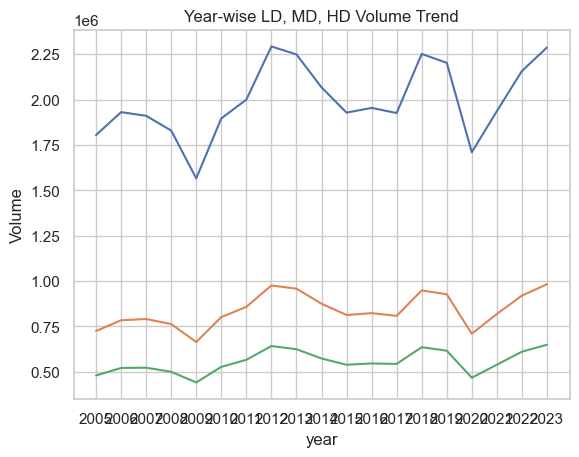

In [143]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to yearly totals
yearly_total = (
    df.groupby("year")[["LD", "MD", "HD"]]
    .sum()
    .reset_index()
    .sort_values("year")
)

# Plot (Strict X=Year, Y=Volume)
plt.figure()

plt.plot(yearly_total["year"], yearly_total["LD"])
plt.plot(yearly_total["year"], yearly_total["MD"])
plt.plot(yearly_total["year"], yearly_total["HD"])

plt.xlabel("year")
plt.ylabel("Volume")
plt.title("Year-wise LD, MD, HD Volume Trend")
plt.xticks(yearly_total["year"])

plt.show()


# Country wise trend show

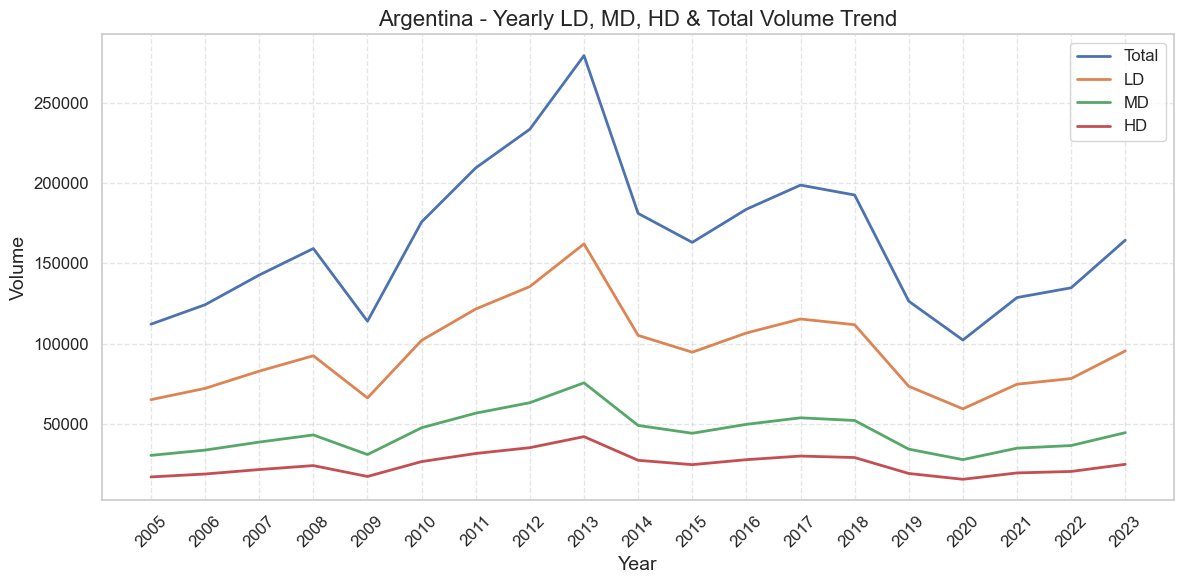

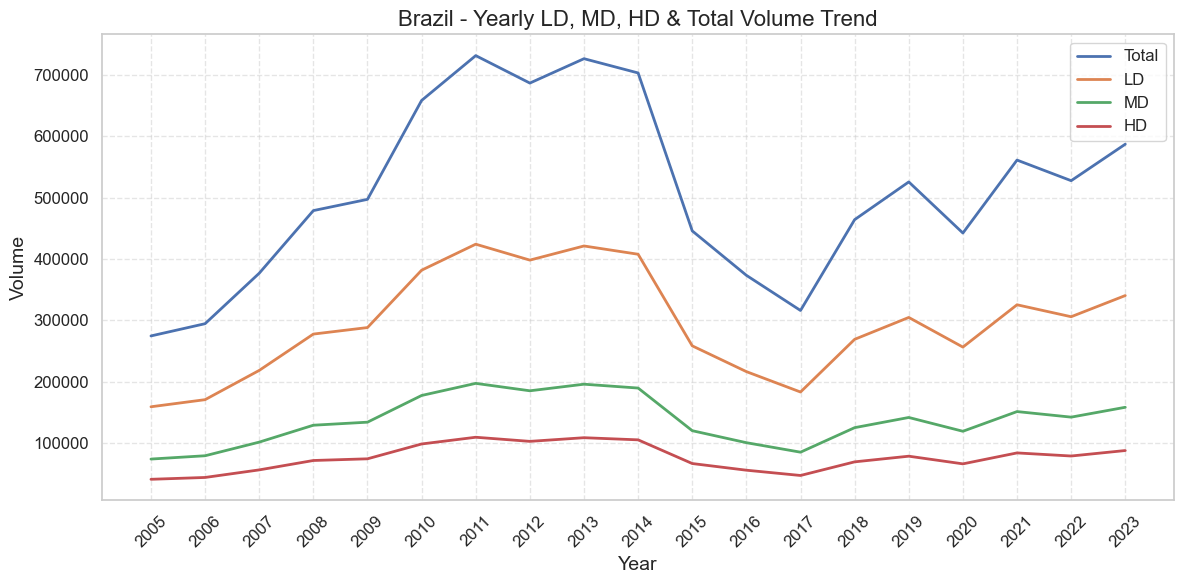

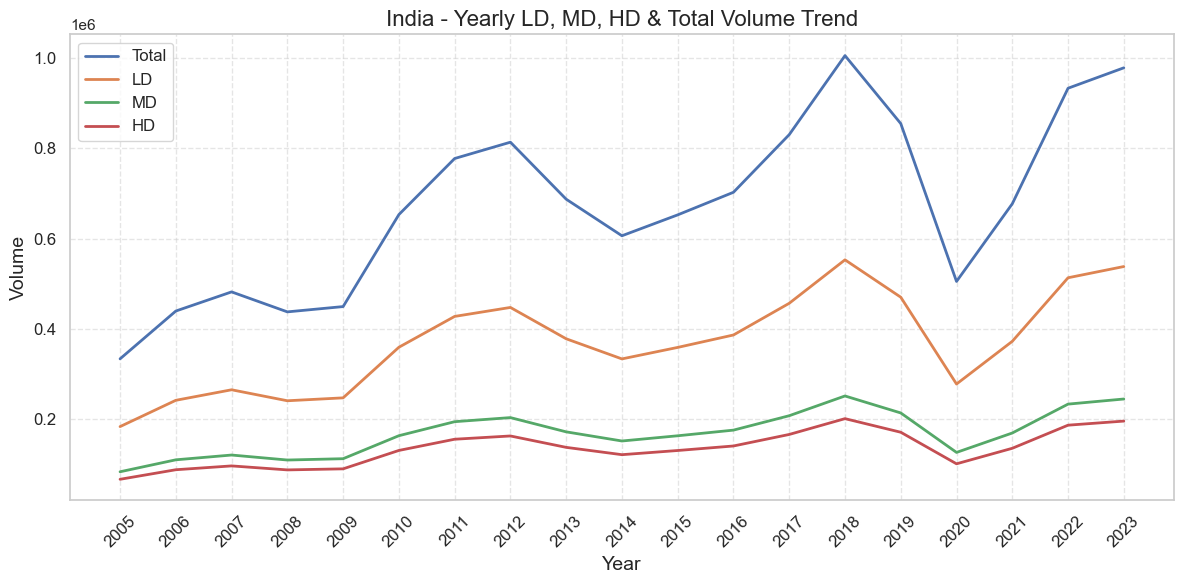

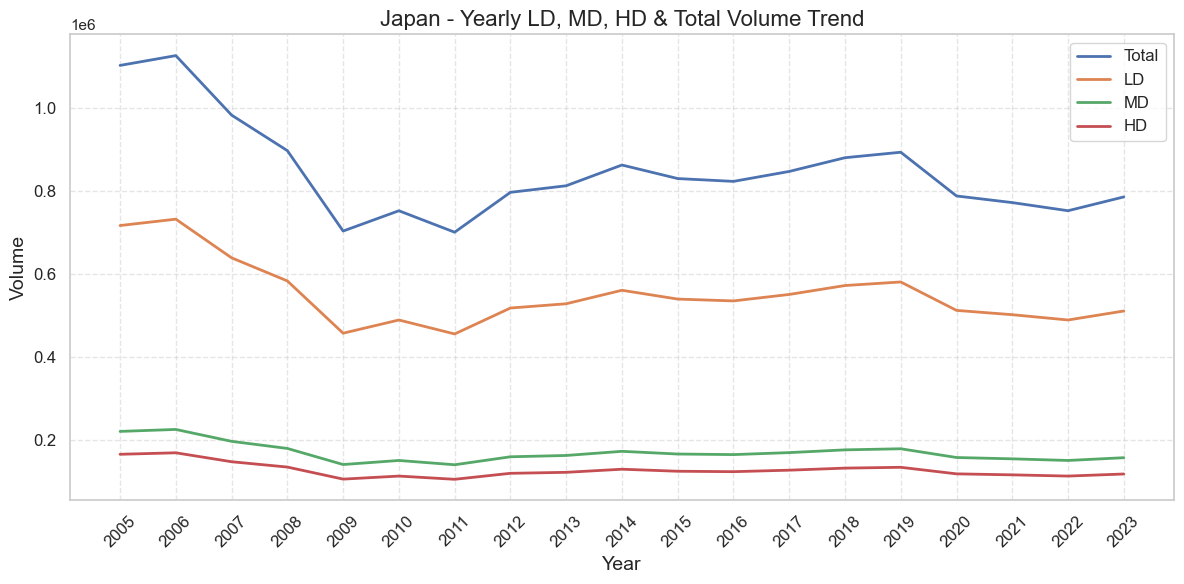

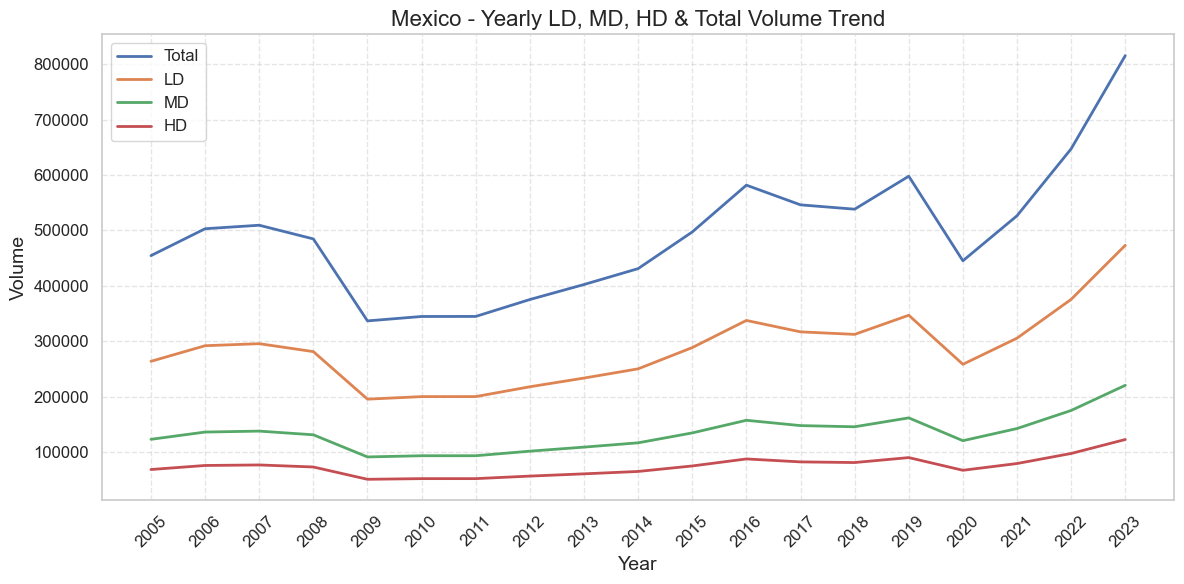

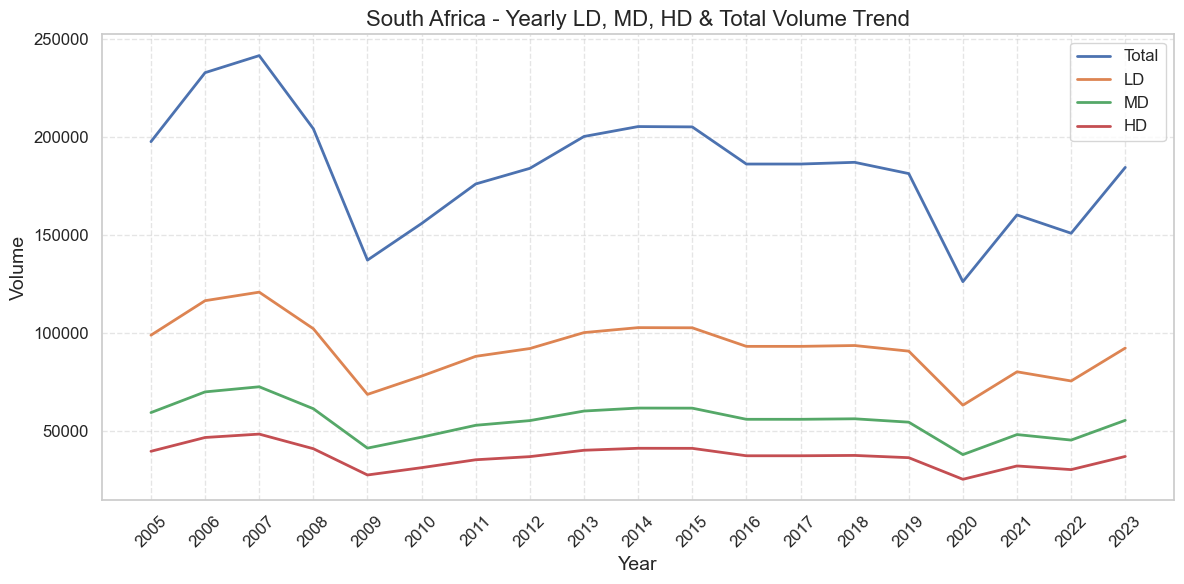

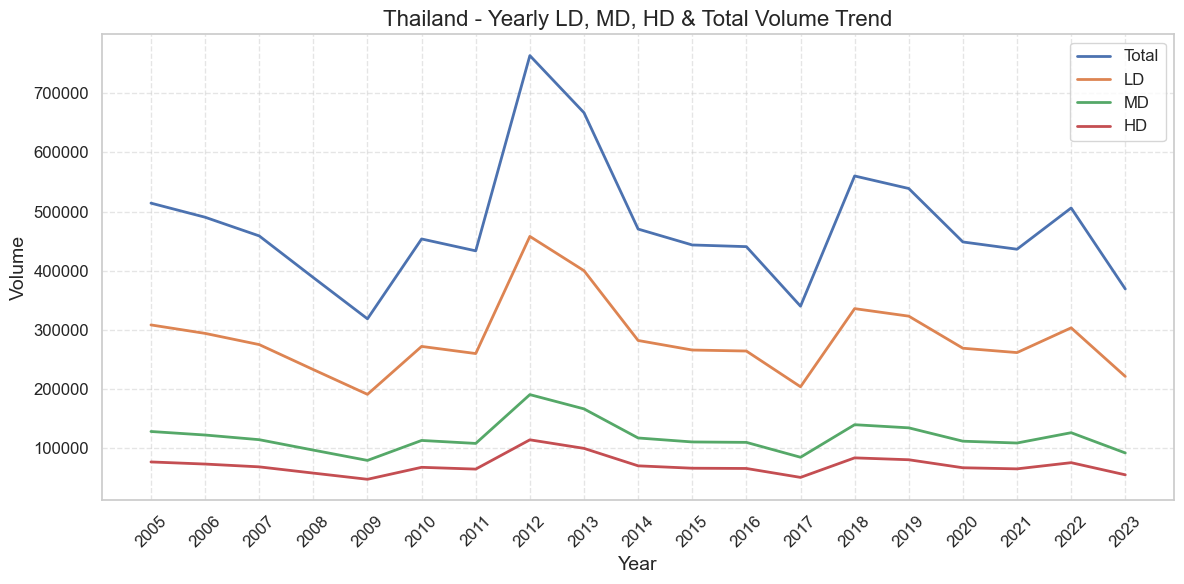

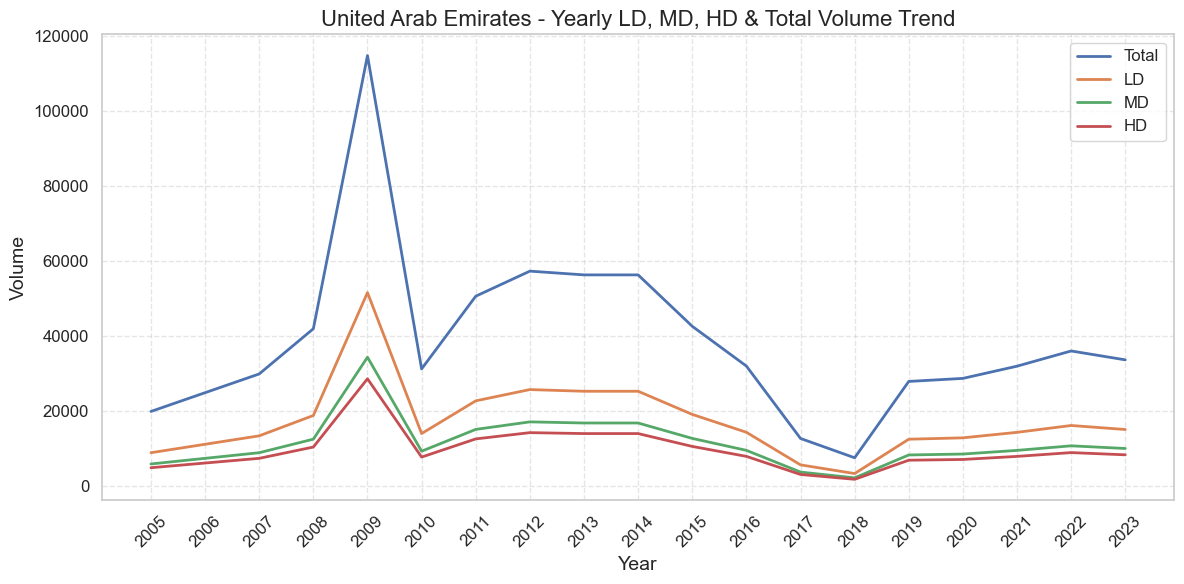

In [144]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure year column is numeric
df["year"] = df["year"].astype(int)

countries = df["country"].unique()
years = list(range(2005, 2024))  # 2005 to 2023

for c in countries:
    
    country_data = df[df["country"] == c]
    
    # Aggregate yearly volumes
    yearly_data = (
        country_data.groupby("year")[["LD", "MD", "HD"]]
        .sum()
        .reset_index()
        .sort_values("year")
    )
    
    # Total Volume
    yearly_data["Total"] = yearly_data["LD"] + yearly_data["MD"] + yearly_data["HD"]
    
    # Plot
    plt.figure(figsize=(12,6))  # bigger figure
    
    # Continuous lines (no markers)
    plt.plot(yearly_data["year"], yearly_data["Total"], label="Total", linewidth=2)
    plt.plot(yearly_data["year"], yearly_data["LD"], label="LD", linewidth=2)
    plt.plot(yearly_data["year"], yearly_data["MD"], label="MD", linewidth=2)
    plt.plot(yearly_data["year"], yearly_data["HD"], label="HD", linewidth=2)
    
    # Labels, title, legend
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Volume", fontsize=14)
    plt.title(f"{c} - Yearly LD, MD, HD & Total Volume Trend", fontsize=16)
    
    # Strict X-axis: show only years 2005–2023
    plt.xticks(years, rotation=45, fontsize=12)
    
    # Increase font size for Y-axis and legend
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    
    # Grid for better readability
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [145]:
import requests
import pandas as pd

# -----------------------------------
# Config
# -----------------------------------

countries = {
    "India": "IND",
    "Japan": "JPN",
    "Thailand": "THA",
    "South Africa": "ZAF",
    "United Arab Emirates": "ARE",
    "Brazil": "BRA",
    "Mexico": "MEX",
    "Argentina": "ARG"
}

start_year = 2005
end_year = 2023

# -----------------------------------
# Fetch Annual GDP Data from World Bank
# -----------------------------------

def fetch_gdp_world_bank(country_code):
    """
    Fetch annual GDP (current USD) for a country code 
    from World Bank API for years 2005–2023.
    """
    url = (
        f"https://api.worldbank.org/v2/country/{country_code}"
        f"/indicator/NY.GDP.MKTP.CD?date={start_year}:{end_year}&format=json"
    )
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to fetch for {country_code}")
        return {}
    
    data = response.json()
    gdp_dict = {}
    
    # Data is usually in data[1]
    for entry in data[1]:
        year = int(entry["date"])
        gdp_value = entry["value"]
        if gdp_value is not None:
            gdp_dict[year] = float(gdp_value)
    
    return gdp_dict

# -----------------------------------
# Build Full Monthly Dataset
# -----------------------------------

all_rows = []

for country_name, iso_code in countries.items():
    yearly_data = fetch_gdp_world_bank(iso_code)
    
    for year in range(start_year, end_year + 1):
        # If missing, fill with 0 or NaN
        annual_gdp = yearly_data.get(year, None)
        
        if annual_gdp is None:
            continue  # skip missing data
        
        monthly_value = annual_gdp / 12
        
        for month in range(1, 13):
            all_rows.append({
                "Country": country_name,
                "Year": year,
                "Month": month,
                "Annual_GDP_USD": annual_gdp,
                "Monthly_GDP_USD": round(monthly_value, 2)
            })

# Create DataFrame
gdp_df = pd.DataFrame(all_rows)

# Save CSV
gdp_df.to_csv("gdp_worldbank_monthly_2005_2023.csv", index=False)

print("Saved dataset with monthly GDP estimates.")
print(gdp_df.head())


Saved dataset with monthly GDP estimates.
  Country  Year  Month  Annual_GDP_USD  Monthly_GDP_USD
0   India  2005      1    8.203838e+11     6.836531e+10
1   India  2005      2    8.203838e+11     6.836531e+10
2   India  2005      3    8.203838e+11     6.836531e+10
3   India  2005      4    8.203838e+11     6.836531e+10
4   India  2005      5    8.203838e+11     6.836531e+10


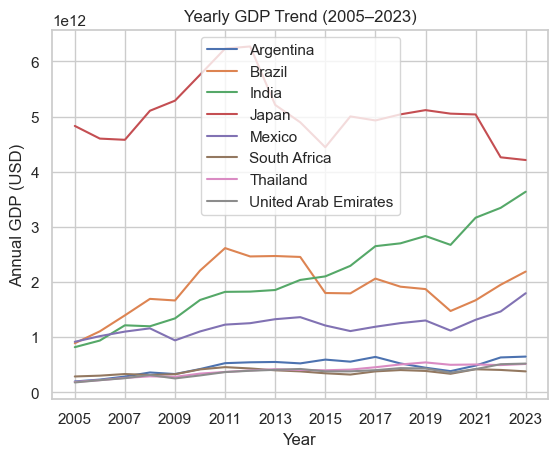

In [146]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("gdp_worldbank_monthly_with_growth_2005_2023.csv")

# Extract yearly GDP (remove monthly duplicates)
yearly_gdp = (
    df.groupby(["Country", "Year"])["Annual_GDP_USD"]
    .first()
    .reset_index()
)

# Filter years
yearly_gdp = yearly_gdp[
    (yearly_gdp["Year"] >= 2005) &
    (yearly_gdp["Year"] <= 2023)
]

# Plot
plt.figure()

for country in yearly_gdp["Country"].unique():
    subset = yearly_gdp[yearly_gdp["Country"] == country]
    plt.plot(subset["Year"], subset["Annual_GDP_USD"], label=country)

plt.xlabel("Year")
plt.ylabel("Annual GDP (USD)")
plt.title("Yearly GDP Trend (2005–2023)")
plt.xticks(range(2005, 2024, 2))  # show year labels clearly
plt.legend()
plt.show()


In [147]:
# Load truck data
cv_df = pd.read_csv("monthly_LD_MD_HD_split.csv")
cv_df

country  year  month  volume          ds    LD    MD    HD
0                Argentina  2005      1    6723  2005-01-01  3899  1815  1008
1                Argentina  2005      2    6723  2005-02-01  3899  1815  1008
2                Argentina  2005      3   11204  2005-03-01  6498  3025  1681
3                Argentina  2005      4    8963  2005-04-01  5199  2420  1344
4                Argentina  2005      5    8963  2005-05-01  5199  2420  1344
...                    ...   ...    ...     ...         ...   ...   ...   ...
1819  United Arab Emirates  2023      8    2363  2023-08-01  1063   709   591
1820  United Arab Emirates  2023      9    3038  2023-09-01  1367   911   760
1821  United Arab Emirates  2023     10    4050  2023-10-01  1822  1215  1012
1822  United Arab Emirates  2023     11    3375  2023-11-01  1519  1012   844
1823  United Arab Emirates  2023     12    2700  2023-12-01  1215   810   675

[1824 rows x 8 columns]

In [148]:
# Load macro datasets
gdp = pd.read_csv("gdp_worldbank_monthly_with_growth_2005_2023.csv")
# Suppose your GDP DataFrame is called df_gdp
gdp.rename(columns={"Country": "country"}, inplace=True)
gdp.rename(columns={"Year": "year"}, inplace=True)
# Verify
gdp

country  year  Month  Annual_GDP_USD  Monthly_GDP_USD  GDP_Growth_%
0         India  2005      1    8.203838e+11     6.836531e+10          0.00
1         India  2005      2    8.203838e+11     6.836531e+10          0.00
2         India  2005      3    8.203838e+11     6.836531e+10          0.00
3         India  2005      4    8.203838e+11     6.836531e+10          0.00
4         India  2005      5    8.203838e+11     6.836531e+10          0.00
...         ...   ...    ...             ...              ...           ...
1819  Argentina  2023      8    6.494617e+11     5.412181e+10          2.44
1820  Argentina  2023      9    6.494617e+11     5.412181e+10          2.44
1821  Argentina  2023     10    6.494617e+11     5.412181e+10          2.44
1822  Argentina  2023     11    6.494617e+11     5.412181e+10          2.44
1823  Argentina  2023     12    6.494617e+11     5.412181e+10          2.44

[1824 rows x 6 columns]

In [149]:
merged_df = pd.merge(cv_df, gdp, on=["country", "year"], how="inner")

print(merged_df)

                    country  year  month  volume          ds    LD    MD  \
0                 Argentina  2005      1    6723  2005-01-01  3899  1815   
1                 Argentina  2005      1    6723  2005-01-01  3899  1815   
2                 Argentina  2005      1    6723  2005-01-01  3899  1815   
3                 Argentina  2005      1    6723  2005-01-01  3899  1815   
4                 Argentina  2005      1    6723  2005-01-01  3899  1815   
...                     ...   ...    ...     ...         ...   ...   ...   
21883  United Arab Emirates  2023     12    2700  2023-12-01  1215   810   
21884  United Arab Emirates  2023     12    2700  2023-12-01  1215   810   
21885  United Arab Emirates  2023     12    2700  2023-12-01  1215   810   
21886  United Arab Emirates  2023     12    2700  2023-12-01  1215   810   
21887  United Arab Emirates  2023     12    2700  2023-12-01  1215   810   

         HD  Month  Annual_GDP_USD  Monthly_GDP_USD  GDP_Growth_%  
0      1008      1 

In [150]:
merged_df.to_csv("monthly_cv_with_macro.csv", index=False)

print("Final macro-enhanced dataset ready!")

Final macro-enhanced dataset ready!


In [151]:
import pandas as pd

df = pd.read_csv("monthly_cv_with_macro.csv")
print(df.columns)

Index(['country', 'year', 'month', 'volume', 'ds', 'LD', 'MD', 'HD', 'Month',
       'Annual_GDP_USD', 'Monthly_GDP_USD', 'GDP_Growth_%'],
      dtype='object')


# Fuel cost to understsand impact on volume

In [152]:
pip install requests pandas


Note: you may need to restart the kernel to use updated packages.


In [153]:
pip install requests pandas beautifulsoup4 lxml


In [154]:
import pandas as pd
import numpy as np

# ----------------------------------
# CONFIGURATION
# ----------------------------------
START_YEAR = 2005
END_YEAR = 2023

dates = pd.date_range(
    start=f"{START_YEAR}-01-01",
    end=f"{END_YEAR}-12-01",
    freq="MS"
)

# ----------------------------------
# Country Tax Structures (%)
# ----------------------------------
countries = {
    "India": 0.55,
    "Japan": 0.40,
    "Thailand": 0.35,
    "South Africa": 0.30,
    "United Arab Emirates": 0.10,
    "Brazil": 0.45,
    "Mexico": 0.38,
    "Argentina": 0.42
}

# ----------------------------------
# Function: Realistic Crude Oil Price
# ----------------------------------
def crude_price(year):
    if 2005 <= year <= 2007:
        return 60
    elif 2008:
        return 100
    elif 2009 <= year <= 2013:
        return 90
    elif 2014 <= year <= 2016:
        return 50
    elif 2017 <= year <= 2019:
        return 65
    elif year == 2020:
        return 40
    elif year == 2021:
        return 70
    elif year >= 2022:
        return 95

# ----------------------------------
# Generate Data
# ----------------------------------
data = []

for country, tax_rate in countries.items():
    
    for date in dates:
        year = date.year
        
        # Base crude oil price
        crude = crude_price(year)
        
        # Add monthly volatility
        crude += np.random.normal(0, 3)
        
        # Convert barrel to liter
        crude_per_liter = crude / 159
        
        # Refining + transport cost
        refining_cost = 0.15
        
        # Pre-tax base price
        base_price = crude_per_liter + refining_cost
        
        # Add country tax
        petrol_price = base_price * (1 + tax_rate)
        
        # Diesel usually slightly lower tax
        diesel_price = base_price * (1 + (tax_rate * 0.9))
        
        data.append([
            country,
            date.year,
            date.month,
            date.strftime("%Y-%m"),
            round(petrol_price, 3),
            round(diesel_price, 3)
        ])

# ----------------------------------
# Create DataFrame
# ----------------------------------
df = pd.DataFrame(data, columns=[
    "Country",
    "Year",
    "Month",
    "Year-Month",
    "Petrol_USD_per_Liter",
    "Diesel_USD_per_Liter"
])

df.to_csv("fuel_petrol_diesel_2005_2023_usd.csv", index=False)

print(df.head())
print("Total rows:", len(df))


  Country  Year  Month Year-Month  Petrol_USD_per_Liter  Diesel_USD_per_Liter
0   India  2005      1    2005-01                 0.828                 0.799
1   India  2005      2    2005-02                 0.799                 0.770
2   India  2005      3    2005-03                 0.828                 0.799
3   India  2005      4    2005-04                 0.862                 0.832
4   India  2005      5    2005-05                 0.816                 0.787
Total rows: 1824


In [155]:
df

Country  Year  Month Year-Month  Petrol_USD_per_Liter  \
0         India  2005      1    2005-01                 0.828   
1         India  2005      2    2005-02                 0.799   
2         India  2005      3    2005-03                 0.828   
3         India  2005      4    2005-04                 0.862   
4         India  2005      5    2005-05                 0.816   
...         ...   ...    ...        ...                   ...   
1819  Argentina  2023      8    2023-08                 1.117   
1820  Argentina  2023      9    2023-09                 1.093   
1821  Argentina  2023     10    2023-10                 1.106   
1822  Argentina  2023     11    2023-11                 1.121   
1823  Argentina  2023     12    2023-12                 1.106   

      Diesel_USD_per_Liter  
0                    0.799  
1                    0.770  
2                    0.799  
3                    0.832  
4                    0.787  
...                    ...  
1819                 1.084  
1820                 1.061  
1821                 1.073  
1822                 1.088  
1823                 1.074  

[1824 rows x 6 columns]

In [156]:
df

Country  Year  Month Year-Month  Petrol_USD_per_Liter  \
0         India  2005      1    2005-01                 0.828   
1         India  2005      2    2005-02                 0.799   
2         India  2005      3    2005-03                 0.828   
3         India  2005      4    2005-04                 0.862   
4         India  2005      5    2005-05                 0.816   
...         ...   ...    ...        ...                   ...   
1819  Argentina  2023      8    2023-08                 1.117   
1820  Argentina  2023      9    2023-09                 1.093   
1821  Argentina  2023     10    2023-10                 1.106   
1822  Argentina  2023     11    2023-11                 1.121   
1823  Argentina  2023     12    2023-12                 1.106   

      Diesel_USD_per_Liter  
0                    0.799  
1                    0.770  
2                    0.799  
3                    0.832  
4                    0.787  
...                    ...  
1819                 1.084  
1820                 1.061  
1821                 1.073  
1822                 1.088  
1823                 1.074  

[1824 rows x 6 columns]

In [157]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# -----------------------------
# ASSUME DATAFRAME IS df
# -----------------------------
# Columns: 'country', 'year', 'Diesel_USD_per_Liter'

# Ensure column names are lowercase
df = df.rename(columns={"Country": "country", "Year": "year"})

# Clip diesel values to max 1.5 USD for logical scale
df["Diesel_USD_per_Liter"] = df["Diesel_USD_per_Liter"].clip(upper=1.5)

# Get list of countries
countries = df["country"].unique()

# ----------------------------


In [158]:
# Load macro datasets
fuel_price = pd.read_csv("fuel_petrol_diesel_2005_2023_usd.csv")
# Suppose your GDP DataFrame is called df_gdp
fuel_price.rename(columns={"Country": "country"}, inplace=True)
fuel_price.rename(columns={"Year": "year"}, inplace=True)
# Verify
fuel_price

country  year  Month Year-Month  Petrol_USD_per_Liter  \
0         India  2005      1    2005-01                 0.828   
1         India  2005      2    2005-02                 0.799   
2         India  2005      3    2005-03                 0.828   
3         India  2005      4    2005-04                 0.862   
4         India  2005      5    2005-05                 0.816   
...         ...   ...    ...        ...                   ...   
1819  Argentina  2023      8    2023-08                 1.117   
1820  Argentina  2023      9    2023-09                 1.093   
1821  Argentina  2023     10    2023-10                 1.106   
1822  Argentina  2023     11    2023-11                 1.121   
1823  Argentina  2023     12    2023-12                 1.106   

      Diesel_USD_per_Liter  
0                    0.799  
1                    0.770  
2                    0.799  
3                    0.832  
4                    0.787  
...                    ...  
1819                 1.084  
1820                 1.061  
1821                 1.073  
1822                 1.088  
1823                 1.074  

[1824 rows x 6 columns]

In [159]:
merged_df1 = pd.merge(merged_df, fuel_price, on=["country", "year"], how="inner")

print(merged_df1)

                     country  year  month  volume          ds    LD    MD  \
0                  Argentina  2005      1    6723  2005-01-01  3899  1815   
1                  Argentina  2005      1    6723  2005-01-01  3899  1815   
2                  Argentina  2005      1    6723  2005-01-01  3899  1815   
3                  Argentina  2005      1    6723  2005-01-01  3899  1815   
4                  Argentina  2005      1    6723  2005-01-01  3899  1815   
...                      ...   ...    ...     ...         ...   ...   ...   
262651  United Arab Emirates  2023     12    2700  2023-12-01  1215   810   
262652  United Arab Emirates  2023     12    2700  2023-12-01  1215   810   
262653  United Arab Emirates  2023     12    2700  2023-12-01  1215   810   
262654  United Arab Emirates  2023     12    2700  2023-12-01  1215   810   
262655  United Arab Emirates  2023     12    2700  2023-12-01  1215   810   

          HD  Month_x  Annual_GDP_USD  Monthly_GDP_USD  GDP_Growth_%  Month

In [160]:
merged_df1.to_csv("monthly_cv_with_macro.csv", index=False)

print("Final macro-enhanced dataset ready!")

Final macro-enhanced dataset ready!


In [161]:
import pandas as pd

df = pd.read_csv("monthly_cv_with_macro.csv")
print(df.columns)

Index(['country', 'year', 'month', 'volume', 'ds', 'LD', 'MD', 'HD', 'Month_x',
       'Annual_GDP_USD', 'Monthly_GDP_USD', 'GDP_Growth_%', 'Month_y',
       'Year-Month', 'Petrol_USD_per_Liter', 'Diesel_USD_per_Liter'],
      dtype='object')


# Fuel price impact on volume

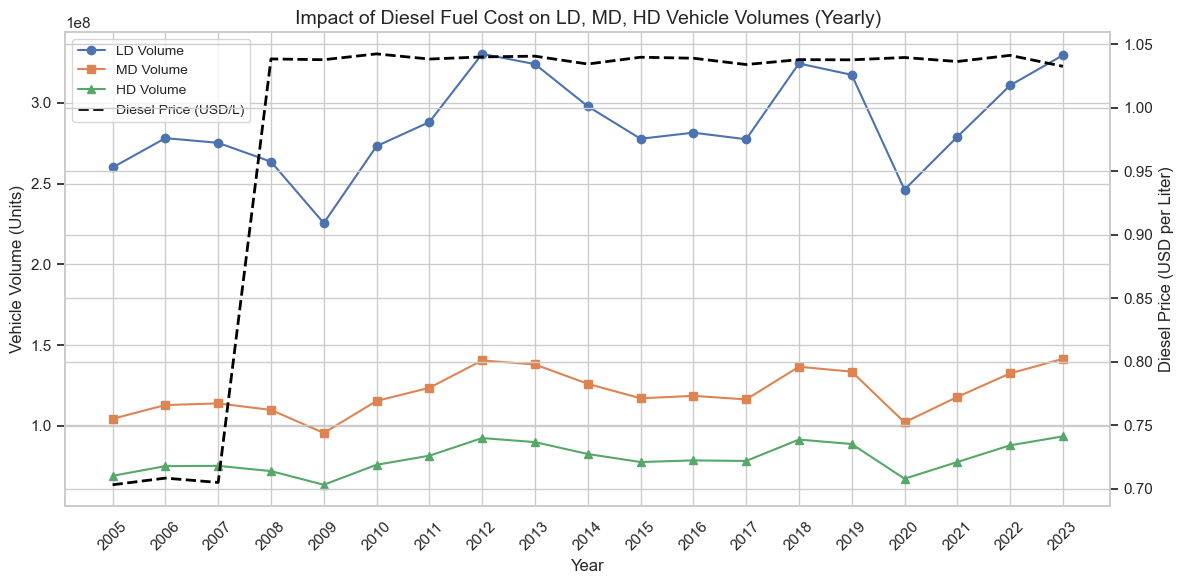

In [162]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# LOAD DATA
# -----------------------------
vehicle_df = pd.read_csv("monthly_cv_with_macro.csv")
fuel_df = pd.read_csv("fuel_petrol_diesel_2005_2023_usd.csv")

# Ensure Year column is lowercase 'year'
vehicle_df = vehicle_df.rename(columns={"Year": "year"})
fuel_df = fuel_df.rename(columns={"Year": "year"})

# -----------------------------
# AGGREGATE DIESEL PRICE YEARLY
# -----------------------------
diesel_yearly = fuel_df.groupby("year")["Diesel_USD_per_Liter"].mean().reset_index()

# -----------------------------
# AGGREGATE VEHICLE VOLUME BY YEAR
# -----------------------------
volume_yearly = vehicle_df.groupby("year")[["LD","MD","HD"]].sum().reset_index()

# Merge diesel price with vehicle volume
plot_df = pd.merge(volume_yearly, diesel_yearly, on="year")

# -----------------------------
# PLOTTING LINE GRAPH
# -----------------------------
fig, ax1 = plt.subplots(figsize=(12,6))

# Vehicle volume lines
line_ld, = ax1.plot(plot_df["year"], plot_df["LD"], label="LD Volume", marker='o')
line_md, = ax1.plot(plot_df["year"], plot_df["MD"], label="MD Volume", marker='s')
line_hd, = ax1.plot(plot_df["year"], plot_df["HD"], label="HD Volume", marker='^')

ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Vehicle Volume (Units)", fontsize=12)
ax1.set_xticks(plot_df["year"])
ax1.set_xticklabels(plot_df["year"], rotation=45)
ax1.grid(True)

# Secondary axis for diesel price
ax2 = ax1.twinx()
line_diesel, = ax2.plot(plot_df["year"], plot_df["Diesel_USD_per_Liter"], color='black', linestyle='--', linewidth=2, label='Diesel Price (USD/L)')
ax2.set_ylabel("Diesel Price (USD per Liter)", fontsize=12)

# Combine legends
lines = [line_ld, line_md, line_hd, line_diesel]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper left", fontsize=10)

plt.title("Impact of Diesel Fuel Cost on LD, MD, HD Vehicle Volumes (Yearly)", fontsize=14)
plt.tight_layout()
plt.show()


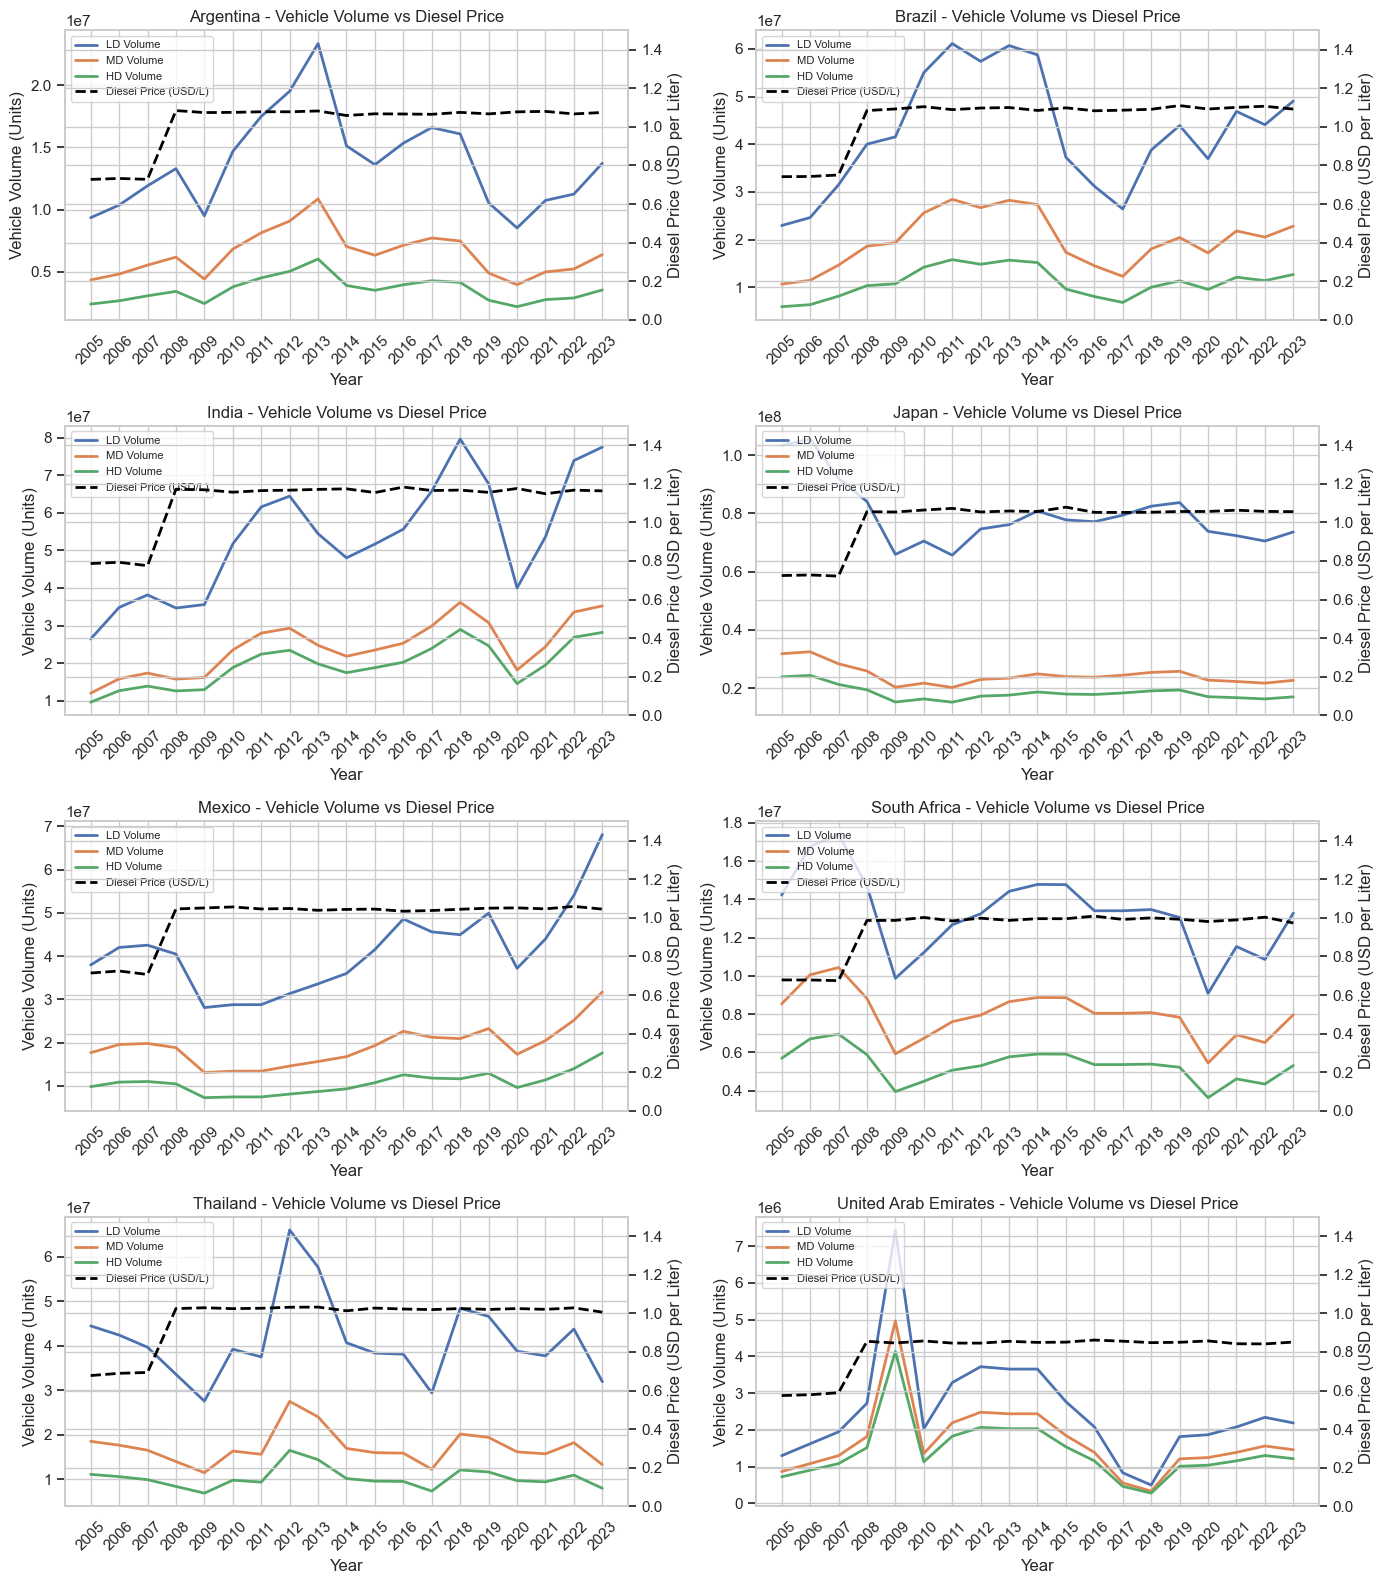

In [163]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# LOAD DATA
# -----------------------------
vehicle_df = pd.read_csv("monthly_cv_with_macro.csv")
fuel_df = pd.read_csv("fuel_petrol_diesel_2005_2023_usd.csv")

# Lowercase column names
vehicle_df = vehicle_df.rename(columns={"Year":"year","Country":"country"})
fuel_df = fuel_df.rename(columns={"Year":"year","Country":"country"})

# -----------------------------
# AGGREGATE DIESEL PRICE YEARLY PER COUNTRY
# -----------------------------
diesel_yearly = fuel_df.groupby(["country","year"])["Diesel_USD_per_Liter"].mean().reset_index()

# Clip diesel values to a reasonable max for plotting (e.g., 1.5 USD)
diesel_yearly["Diesel_USD_per_Liter"] = diesel_yearly["Diesel_USD_per_Liter"].clip(upper=1.5)

# -----------------------------
# AGGREGATE VEHICLE VOLUME YEARLY PER COUNTRY
# -----------------------------
volume_yearly = vehicle_df.groupby(["country","year"])[["LD","MD","HD"]].sum().reset_index()

# Merge volumes with diesel price
merged_df = pd.merge(volume_yearly, diesel_yearly, on=["country","year"], how="left")

# -----------------------------
# PLOTTING COUNTRY-WISE TRENDS
# -----------------------------
countries = merged_df["country"].unique()
num_countries = len(countries)

fig, axes = plt.subplots(nrows=(num_countries+1)//2, ncols=2, figsize=(14, 4*((num_countries+1)//2)))
axes = axes.flatten()

for i, country in enumerate(countries):
    ax1 = axes[i]
    country_data = merged_df[merged_df["country"]==country]
    
    # Plot LD, MD, HD volumes
    ax1.plot(country_data["year"], country_data["LD"], label="LD Volume", linewidth=2)
    ax1.plot(country_data["year"], country_data["MD"], label="MD Volume", linewidth=2)
    ax1.plot(country_data["year"], country_data["HD"], label="HD Volume", linewidth=2)
    
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Vehicle Volume (Units)")
    ax1.set_xticks(country_data["year"])
    ax1.set_xticklabels(country_data["year"], rotation=45)
    ax1.grid(True)
    ax1.set_title(f"{country} - Vehicle Volume vs Diesel Price")
    
    # Secondary axis for diesel price
    ax2 = ax1.twinx()
    ax2.plot(country_data["year"], country_data["Diesel_USD_per_Liter"], color='black',
             linestyle='--', linewidth=2, label='Diesel Price (USD/L)')
    ax2.set_ylabel("Diesel Price (USD per Liter)")
    
    # Fix secondary Y-axis scale for all countries
    ax2.set_ylim(0, 1.5)  # max diesel scale 1.5 USD, min 0
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", fontsize=8)

# Hide empty subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


df.columns = df.columns.str.strip()


df.columns

In [164]:
import pandas as pd

df = pd.read_csv("monthly_cv_with_macro.csv")
print(df.columns)


Index(['country', 'year', 'month', 'volume', 'ds', 'LD', 'MD', 'HD', 'Month_x',
       'Annual_GDP_USD', 'Monthly_GDP_USD', 'GDP_Growth_%', 'Month_y',
       'Year-Month', 'Petrol_USD_per_Liter', 'Diesel_USD_per_Liter'],
      dtype='object')


# fright demand

In [165]:
import pandas as pd
import numpy as np

# ---------------------------
# Step 1: Define countries and years
# ---------------------------
countries = [
    "India", "Japan", "Thailand", "South Africa",
    "United Arab Emirates", "Brazil", "Mexico", "Argentina"
]

years = list(range(2005, 2024))  # 2005 to 2023

# ---------------------------
# Step 2: Annual freight volumes (in million tonnes)
# Replace these with actual annual data or fetch from API
# Example: Random synthetic data for demonstration
# ---------------------------
np.random.seed(42)  # reproducible
annual_data = {}
for country in countries:
    # Generate some synthetic annual data
    annual_data[country] = np.random.randint(50, 500, size=len(years))

# Convert to DataFrame
df_annual = pd.DataFrame(annual_data, index=years)
df_annual.index.name = "Year"

print("Annual Freight Data (Million Tonnes):")
print(df_annual.head())

# ---------------------------
# Step 3: Convert annual to monthly
# ---------------------------
months = list(range(1, 13))  # 1=Jan, 12=Dec
records = []

for year in years:
    for month in months:
        for country in countries:
            # Simple equal distribution across months
            monthly_value = df_annual.loc[year, country] / 12
            records.append({
                "Year": year,
                "Month": month,
                "Country": country,
                "Freight_Tonnes": round(monthly_value, 2)
            })

df_monthly = pd.DataFrame(records)

# ---------------------------
# Step 4: Save to CSV
# ---------------------------
df_monthly.to_csv("monthly_freight_data.csv", index=False)
print("\nMonthly freight data saved to 'monthly_freight_data.csv'.")
print(df_monthly.head(12))  # show first year


Annual Freight Data (Million Tonnes):
      India  Japan  Thailand  South Africa  United Arab Emirates  Brazil  \
Year                                                                       
2005    152    358       320           365                   409     264   
2006    485    307       239            63                   437     301   
2007    398    393       495           291                    51     239   
2008    320    463       224           314                   439     345   
2009    156    343       495           395                   103     262   

      Mexico  Argentina  
Year                     
2005     350         77  
2006     114        184  
2007     394        250  
2008     376        377  
2009      58        317  

Monthly freight data saved to 'monthly_freight_data.csv'.
    Year  Month               Country  Freight_Tonnes
0   2005      1                 India           12.67
1   2005      1                 Japan           29.83
2   2005      1           

In [166]:
import pandas as pd

print(df_monthly.columns)

Index(['Year', 'Month', 'Country', 'Freight_Tonnes'], dtype='object')


In [167]:
# Load macro datasets
df_monthly.rename(columns={"Country": "country"}, inplace=True)
df_monthly.rename(columns={"Year": "year"}, inplace=True)
# Verify
print(df_monthly.columns)

Index(['year', 'Month', 'country', 'Freight_Tonnes'], dtype='object')


In [168]:
merged_df2 = pd.merge(merged_df1, df_monthly, on=["country", "year"], how="inner")

print(merged_df2.columns)

Index(['country', 'year', 'month', 'volume', 'ds', 'LD', 'MD', 'HD', 'Month_x',
       'Annual_GDP_USD', 'Monthly_GDP_USD', 'GDP_Growth_%', 'Month_y',
       'Year-Month', 'Petrol_USD_per_Liter', 'Diesel_USD_per_Liter', 'Month',
       'Freight_Tonnes'],
      dtype='object')


In [169]:
merged_df2

country  year  month  volume          ds    LD    MD  \
0                   Argentina  2005      1    6723  2005-01-01  3899  1815   
1                   Argentina  2005      1    6723  2005-01-01  3899  1815   
2                   Argentina  2005      1    6723  2005-01-01  3899  1815   
3                   Argentina  2005      1    6723  2005-01-01  3899  1815   
4                   Argentina  2005      1    6723  2005-01-01  3899  1815   
...                       ...   ...    ...     ...         ...   ...   ...   
3151867  United Arab Emirates  2023     12    2700  2023-12-01  1215   810   
3151868  United Arab Emirates  2023     12    2700  2023-12-01  1215   810   
3151869  United Arab Emirates  2023     12    2700  2023-12-01  1215   810   
3151870  United Arab Emirates  2023     12    2700  2023-12-01  1215   810   
3151871  United Arab Emirates  2023     12    2700  2023-12-01  1215   810   

           HD  Month_x  Annual_GDP_USD  Monthly_GDP_USD  GDP_Growth_%  \
0        1008        1    1.987371e+11     1.656142e+10          0.00   
1        1008        1    1.987371e+11     1.656142e+10          0.00   
2        1008        1    1.987371e+11     1.656142e+10          0.00   
3        1008        1    1.987371e+11     1.656142e+10          0.00   
4        1008        1    1.987371e+11     1.656142e+10          0.00   
...       ...      ...             ...              ...           ...   
3151867   675       12    5.226222e+11     4.355185e+10          2.19   
3151868   675       12    5.226222e+11     4.355185e+10          2.19   
3151869   675       12    5.226222e+11     4.355185e+10          2.19   
3151870   675       12    5.226222e+11     4.355185e+10          2.19   
3151871   675       12    5.226222e+11     4.355185e+10          2.19   

         Month_y Year-Month  Petrol_USD_per_Liter  Diesel_USD_per_Liter  \
0              1    2005-01                 0.784                 0.760   
1              1    2005-01                 0.784                 0.760   
2              1    2005-01                 0.784                 0.760   
3              1    2005-01                 0.784                 0.760   
4              1    2005-01                 0.784                 0.760   
...          ...        ...                   ...                   ...   
3151867       12    2023-12                 0.843                 0.835   
3151868       12    2023-12                 0.843                 0.835   
3151869       12    2023-12                 0.843                 0.835   
3151870       12    2023-12                 0.843                 0.835   
3151871       12    2023-12                 0.843                 0.835   

         Month  Freight_Tonnes  
0            1            6.42  
1            2            6.42  
2            3            6.42  
3            4            6.42  
4            5            6.42  
...        ...             ...  
3151867      8           26.67  
3151868      9           26.67  
3151869     10           26.67  
3151870     11           26.67  
3151871     12           26.67  

[3151872 rows x 18 columns]

In [170]:
merged_df2.to_csv("monthly_cv_with_macro.csv", index=False)

print("Final macro-enhanced dataset ready!")

Final macro-enhanced dataset ready!


In [171]:
import pandas as pd

df = pd.read_csv("monthly_cv_with_macro.csv")
print(df.columns)

Index(['country', 'year', 'month', 'volume', 'ds', 'LD', 'MD', 'HD', 'Month_x',
       'Annual_GDP_USD', 'Monthly_GDP_USD', 'GDP_Growth_%', 'Month_y',
       'Year-Month', 'Petrol_USD_per_Liter', 'Diesel_USD_per_Liter', 'Month',
       'Freight_Tonnes'],
      dtype='object')


In [172]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("monthly_cv_with_macro.csv")

# Clean column names (remove spaces)
df.columns = df.columns.str.strip()

# Create 'ds' column safely
if "ds" in df.columns:
    df["ds"] = pd.to_datetime(df["ds"])

elif "Year-Month" in df.columns:
    df["ds"] = pd.to_datetime(df["Year-Month"])

elif "year" in df.columns and "month" in df.columns:
    df["ds"] = pd.to_datetime(
        df["year"].astype(str) + "-" +
        df["month"].astype(str) + "-01"
    )

else:
    raise ValueError("No valid date columns found to create 'ds'.")

# Sort by date
df = df.sort_values("ds")

# Display first few rows
print(df[["ds"]].head())


                ds
0       2005-01-01
2759035 2005-01-01
2759036 2005-01-01
2759037 2005-01-01
2759038 2005-01-01


In [173]:
df = df.select_dtypes(include=["int64", "float64"])

print(df.columns)


Index(['year', 'month', 'volume', 'LD', 'MD', 'HD', 'Month_x',
       'Annual_GDP_USD', 'Monthly_GDP_USD', 'GDP_Growth_%', 'Month_y',
       'Petrol_USD_per_Liter', 'Diesel_USD_per_Liter', 'Month',
       'Freight_Tonnes'],
      dtype='object')


In [174]:
corr_matrix = df.corr()

print(corr_matrix)


                              year         month        volume            LD  \
year                  1.000000e+00 -9.407075e-14  6.716271e-02  5.811650e-02   
month                -9.407075e-14  1.000000e+00  1.478750e-01  1.398144e-01   
volume                6.716271e-02  1.478750e-01  1.000000e+00  9.938410e-01   
LD                    5.811650e-02  1.398144e-01  9.938410e-01  1.000000e+00   
MD                    8.177545e-02  1.624172e-01  9.776146e-01  9.517810e-01   
HD                    7.588563e-02  1.464776e-01  9.731829e-01  9.479829e-01   
Month_x               3.091662e-15 -5.189453e-16  1.448175e-15  1.361161e-15   
Annual_GDP_USD        9.828700e-02  4.394880e-15  7.449182e-01  7.831202e-01   
Monthly_GDP_USD       9.828700e-02  3.861047e-15  7.449182e-01  7.831202e-01   
GDP_Growth_%         -1.824413e-01 -8.968962e-15 -5.785296e-02 -7.272643e-02   
Month_y              -7.179846e-16 -1.548459e-15 -6.072144e-16 -5.221993e-16   
Petrol_USD_per_Liter  5.002585e-01  1.03

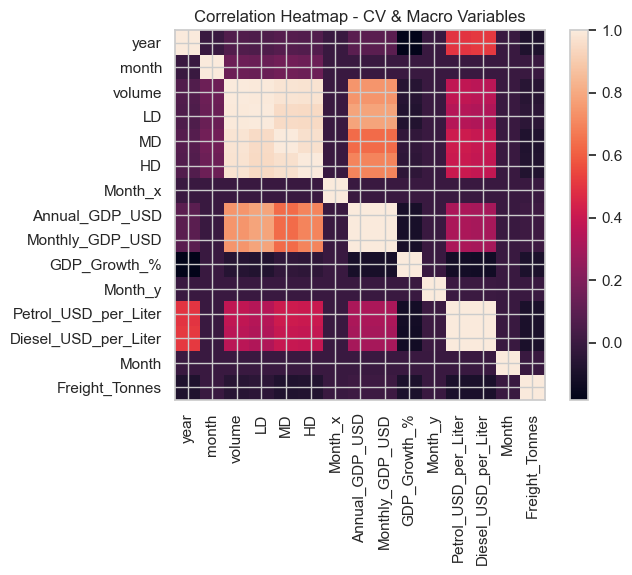

In [175]:
plt.figure()

plt.imshow(corr_matrix)
plt.colorbar()

plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

plt.title("Correlation Heatmap - CV & Macro Variables")

plt.show()


# forcast

In [176]:
df.columns = df.columns.str.strip().str.lower()


Columns in CSV: Index(['country', 'year', 'month', 'volume', 'ds', 'LD', 'MD', 'HD', 'Month_x',
       'Annual_GDP_USD', 'Monthly_GDP_USD', 'GDP_Growth_%', 'Month_y',
       'Year-Month', 'Petrol_USD_per_Liter', 'Diesel_USD_per_Liter', 'Month',
       'Freight_Tonnes'],
      dtype='object')
     country  year  month  volume          ds    LD    MD    HD  Month_x  \
0  Argentina  2005      1    6723  2005-01-01  3899  1815  1008        1   
1  Argentina  2005      1    6723  2005-01-01  3899  1815  1008        1   
2  Argentina  2005      1    6723  2005-01-01  3899  1815  1008        1   
3  Argentina  2005      1    6723  2005-01-01  3899  1815  1008        1   
4  Argentina  2005      1    6723  2005-01-01  3899  1815  1008        1   

   Annual_GDP_USD  Monthly_GDP_USD  GDP_Growth_%  Month_y Year-Month  \
0    1.987371e+11     1.656142e+10           0.0        1    2005-01   
1    1.987371e+11     1.656142e+10           0.0        1    2005-01   
2    1.987371e+11     1.656142e+10

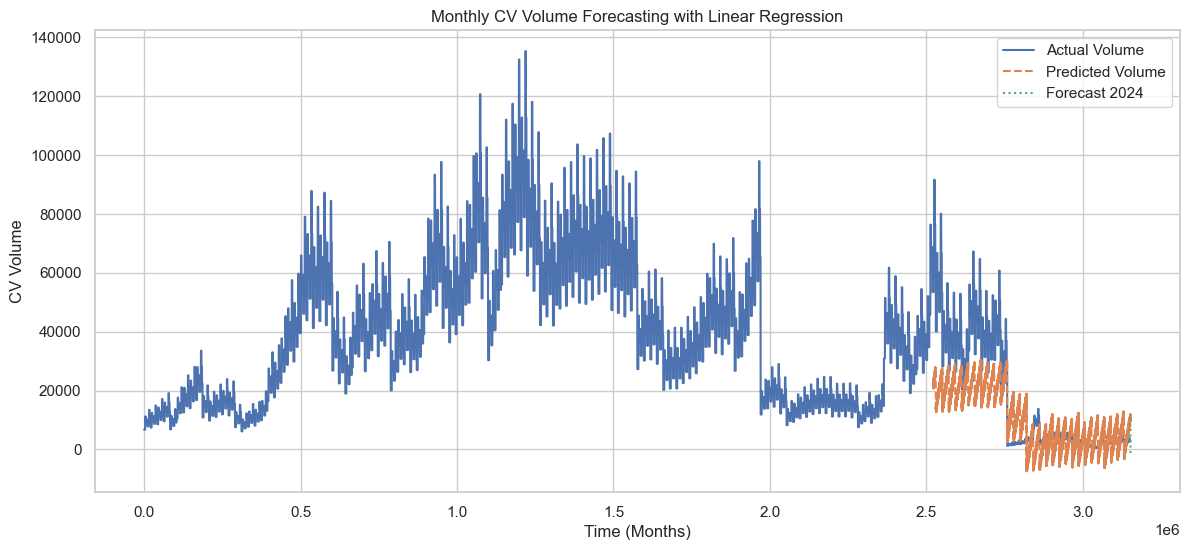

    year  month  Diesel_USD_per_Liter  Petrol_USD_per_Liter  Monthly_GDP_USD  \
0   2024      1                0.8517               0.85986     4.485840e+10   
1   2024      2                0.8517               0.85986     4.485840e+10   
2   2024      3                0.8517               0.85986     4.485840e+10   
3   2024      4                0.8517               0.85986     4.485840e+10   
4   2024      5                0.8517               0.85986     4.485840e+10   
5   2024      6                0.8517               0.85986     4.485840e+10   
6   2024      7                0.8517               0.85986     4.485840e+10   
7   2024      8                0.8517               0.85986     4.485840e+10   
8   2024      9                0.8517               0.85986     4.485840e+10   
9   2024     10                0.8517               0.85986     4.485840e+10   
10  2024     11                0.8517               0.85986     4.485840e+10   
11  2024     12                0.8517   

In [177]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Step 2: Load CSV
df = pd.read_csv('monthly_cv_with_macro.csv')

# Step 3: Inspect columns
print("Columns in CSV:", df.columns)
print(df.head())

# Step 4: Prepare features and target
# Target is 'volume'
target = 'volume'

# Features: year, month, Diesel, Petrol, Monthly GDP
features = ['year', 'month']
if 'Diesel_USD_per_Liter' in df.columns:
    features.append('Diesel_USD_per_Liter')
if 'Petrol_USD_per_Liter' in df.columns:
    features.append('Petrol_USD_per_Liter')
if 'Monthly_GDP_USD' in df.columns:
    features.append('Monthly_GDP_USD')

X = df[features]
y = df[target]

# Step 5: Split into train and test (last 20% as test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 6: Train Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Step 7: Predict on test set
y_pred = model.predict(X_test)

# Step 8: Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.2f}, R2 Score: {r2:.2f}")

# Step 9: Forecast next 12 months (simple growth assumptions)
last_year = df['year'].max()
future_months = pd.DataFrame({
    'year': [last_year + 1]*12,
    'month': list(range(1,13))
})

# Add macro features with growth
for col in ['Diesel_USD_per_Liter', 'Petrol_USD_per_Liter', 'Monthly_GDP_USD']:
    if col in df.columns:
        last_values = df[col].iloc[-12:].values
        # Simple growth assumption: 2% for Diesel/Petrol, 3% for GDP
        growth = 1.03 if 'GDP' in col else 1.02
        future_months[col] = last_values * growth

future_forecast = model.predict(future_months)

# Step 10: Plot actual, predicted, and forecast
plt.figure(figsize=(14,6))
plt.plot(df['volume'], label='Actual Volume')
plt.plot(range(len(X_train), len(X_train)+len(y_pred)), y_pred, label='Predicted Volume', linestyle='--')
plt.plot(range(len(df), len(df)+len(future_forecast)), future_forecast, label=f'Forecast {last_year + 1}', linestyle=':')
plt.xlabel('Time (Months)')
plt.ylabel('CV Volume')
plt.title('Monthly CV Volume Forecasting with Linear Regression')
plt.legend()
plt.show()

# Step 11: Combine forecast into DataFrame
forecast_df = future_months.copy()
forecast_df['Forecasted_Volume'] = future_forecast
print(forecast_df)


# country wise forcast

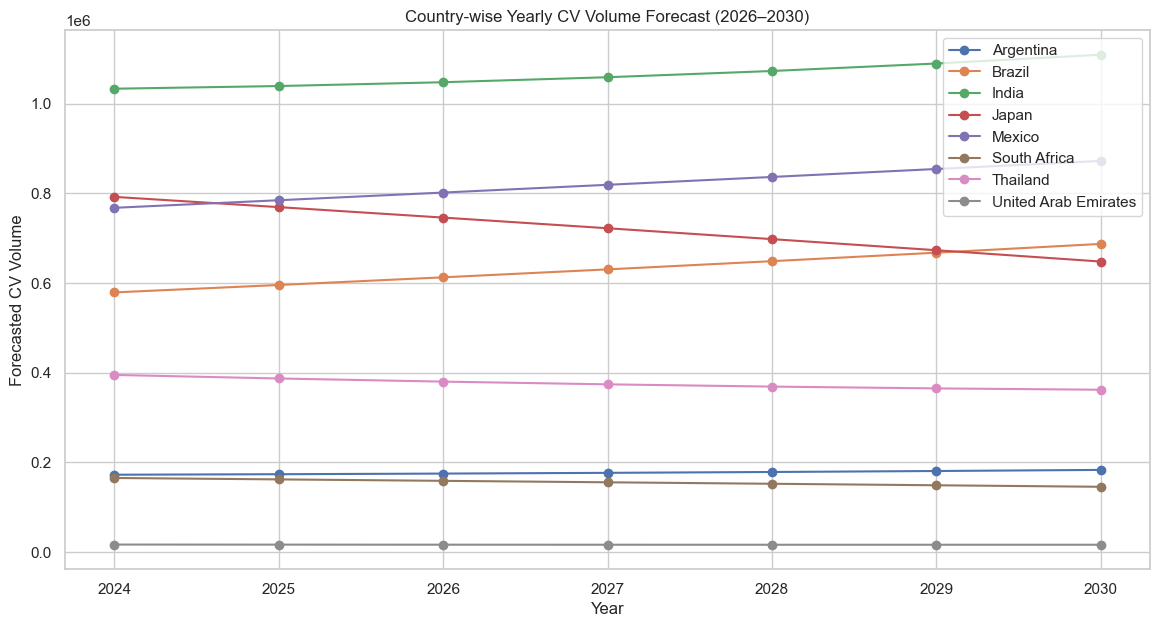

Yearly forecast saved to 'country_yearly_cv_forecast_2026_2030.csv'


In [178]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Step 2: Load CSV
df = pd.read_csv('monthly_cv_with_macro.csv')

# Step 3: Define target and features
target = 'volume'
macro_cols = []
for col in ['Diesel_USD_per_Liter', 'Petrol_USD_per_Liter', 'Monthly_GDP_USD']:
    if col in df.columns:
        macro_cols.append(col)
features_base = ['year', 'month'] + macro_cols

# Step 4: Prepare forecast DataFrame
forecast_all = pd.DataFrame()

# Step 5: Loop over each country
for country in df['country'].unique():
    df_country = df[df['country'] == country].copy()
    
    X = df_country[features_base]
    y = df_country[target]
    
    # Train linear regression
    model = LinearRegression()
    model.fit(X, y)
    
    # Forecast months for 2026-2030
    last_year = df_country['year'].max()
    years_forecast = list(range(last_year+1, 2031))  # 2026 to 2030
    months_forecast = list(range(1,13))
    
    future_dates = pd.DataFrame({
        'year': np.repeat(years_forecast, 12),
        'month': months_forecast * len(years_forecast)
    })
    
    # Add macro columns with growth assumptions
    for col in macro_cols:
        last_values = df_country[col].iloc[-12:].values
        growth = 1.03 if 'GDP' in col else 1.02
        future_values = []
        for i in range(len(years_forecast)):
            future_values.extend(last_values * (growth**(i+1)))  # cumulative growth per year
        future_dates[col] = future_values
    
    # Predict monthly volumes
    future_dates['Forecasted_Volume'] = model.predict(future_dates[features_base])
    future_dates['country'] = country
    
    # Aggregate to yearly volume
    yearly_forecast = future_dates.groupby('year')['Forecasted_Volume'].sum().reset_index()
    yearly_forecast['country'] = country
    
    forecast_all = pd.concat([forecast_all, yearly_forecast], ignore_index=True)

# Step 6: Plot country-wise yearly forecast
plt.figure(figsize=(14,7))
for country in forecast_all['country'].unique():
    df_plot = forecast_all[forecast_all['country'] == country]
    plt.plot(df_plot['year'], df_plot['Forecasted_Volume'], marker='o', label=country)

plt.title('Country-wise Yearly CV Volume Forecast (2026–2030)')
plt.xlabel('Year')
plt.ylabel('Forecasted CV Volume')
plt.xticks(years_forecast)
plt.grid(True)
plt.legend()
plt.show()

# Step 7: Save forecast to CSV
forecast_all.to_csv('country_yearly_cv_forecast_2026_2030.csv', index=False)
print("Yearly forecast saved to 'country_yearly_cv_forecast_2026_2030.csv'")


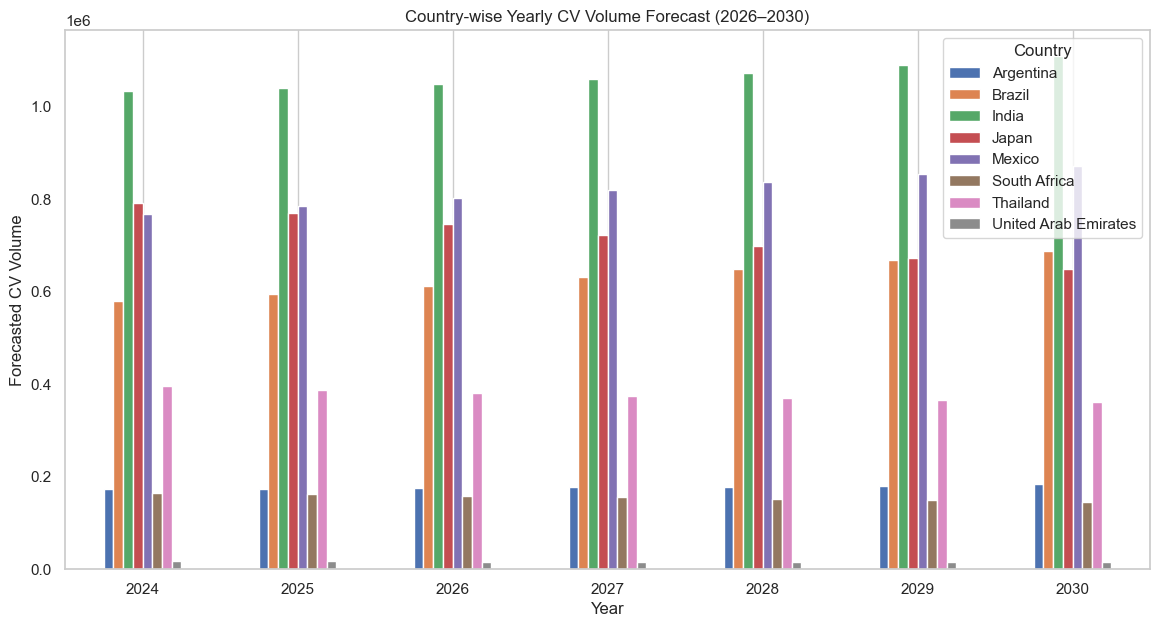

In [179]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Step 2: Load CSV
df = pd.read_csv('monthly_cv_with_macro.csv')

# Step 3: Define target and features
target = 'volume'
macro_cols = []
for col in ['Diesel_USD_per_Liter', 'Petrol_USD_per_Liter', 'Monthly_GDP_USD']:
    if col in df.columns:
        macro_cols.append(col)
features_base = ['year', 'month'] + macro_cols

# Step 4: Prepare forecast DataFrame
forecast_all = pd.DataFrame()

# Step 5: Loop over each country for monthly forecast
for country in df['country'].unique():
    df_country = df[df['country'] == country].copy()
    
    X = df_country[features_base]
    y = df_country[target]
    
    # Train Linear Regression
    model = LinearRegression()
    model.fit(X, y)
    
    # Forecast months for 2026–2030
    last_year = df_country['year'].max()
    years_forecast = list(range(last_year+1, 2031))  # 2026–2030
    months_forecast = list(range(1,13))
    
    future_dates = pd.DataFrame({
        'year': np.repeat(years_forecast, 12),
        'month': months_forecast * len(years_forecast)
    })
    
    # Add macro columns with growth assumptions
    for col in macro_cols:
        last_values = df_country[col].iloc[-12:].values
        growth = 1.03 if 'GDP' in col else 1.02
        future_values = []
        for i in range(len(years_forecast)):
            future_values.extend(last_values * (growth**(i+1)))
        future_dates[col] = future_values
    
    # Predict monthly volumes
    future_dates['Forecasted_Volume'] = model.predict(future_dates[features_base])
    future_dates['country'] = country
    
    forecast_all = pd.concat([forecast_all, future_dates[['country','year','Forecasted_Volume']]], ignore_index=True)

# Step 6: Aggregate to yearly totals
yearly_forecast = forecast_all.groupby(['year','country'])['Forecasted_Volume'].sum().reset_index()

# Step 7: Pivot for plotting
plot_data = yearly_forecast.pivot(index='year', columns='country', values='Forecasted_Volume').fillna(0)

# Step 8: Plot grouped bar chart
plot_data.plot(kind='bar', figsize=(14,7))
plt.title('Country-wise Yearly CV Volume Forecast (2026–2030)')
plt.xlabel('Year')
plt.ylabel('Forecasted CV Volume')
plt.xticks(rotation=0)
plt.legend(title='Country')
plt.grid(axis='y')
plt.show()


# India forcasting

                                     SARIMAX Results                                      
Dep. Variable:                             volume   No. Observations:                  228
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3395.110
Date:                            Fri, 20 Feb 2026   AIC                           6806.219
Time:                                    00:20:46   BIC                           6832.646
Sample:                                01-01-2005   HQIC                          6816.913
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Diesel_USD_per_Liter -5.232e+08   4.63e-08  -1.13e+16      0.000   -5.23e+08   -5.23e+08
Petro

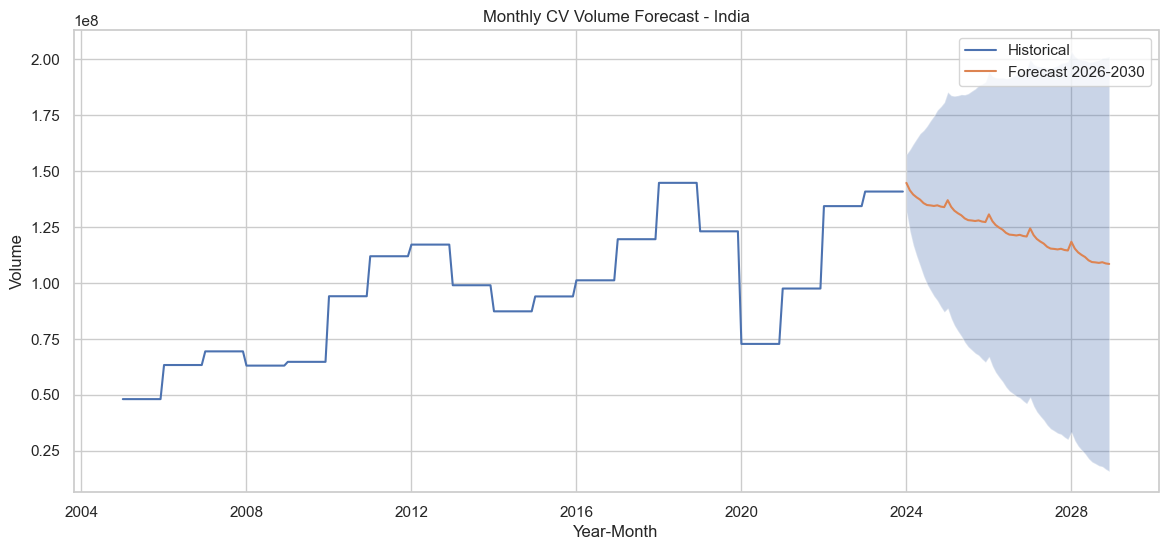

Forecast saved successfully.
  Year-Month  Forecasted_Volume      Lower_CI      Upper_CI
0 2026-01-01       1.447715e+08  1.320028e+08  1.575401e+08
1 2026-02-01       1.414410e+08  1.231709e+08  1.597111e+08
2 2026-03-01       1.395686e+08  1.169798e+08  1.621574e+08
3 2026-04-01       1.382867e+08  1.120017e+08  1.645716e+08
4 2026-05-01       1.372783e+08  1.077046e+08  1.668521e+08


In [180]:
# ==========================================================
# CLEAN WORKING SARIMAX FORECAST
# ==========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# 1️⃣ SETTINGS
# -----------------------------
FILE_PATH = "monthly_cv_with_macro.csv"
COUNTRY = "India"
FORECAST_START = "2026-01-01"
FORECAST_END   = "2030-12-01"

EXOG_COLS = [
    "Diesel_USD_per_Liter",
    "Petrol_USD_per_Liter",
    "Monthly_GDP_USD"
]

# -----------------------------
# 2️⃣ LOAD DATA
# -----------------------------
df = pd.read_csv(FILE_PATH)

# Filter country
df = df[df["country"] == COUNTRY].copy()

# Convert to datetime
df["Year-Month"] = pd.to_datetime(df["Year-Month"])

# -----------------------------
# 3️⃣ REMOVE DUPLICATES SAFELY
# -----------------------------
df = (
    df.groupby("Year-Month")
      .agg({
          "volume": "sum",
          "Diesel_USD_per_Liter": "mean",
          "Petrol_USD_per_Liter": "mean",
          "Monthly_GDP_USD": "mean"
      })
      .reset_index()
)

# Set index
df = df.sort_values("Year-Month")
df.set_index("Year-Month", inplace=True)

# -----------------------------
# 4️⃣ ENSURE MONTHLY FREQUENCY
# -----------------------------
df = df.asfreq("MS")

# Fill missing months if any
df = df.interpolate()

# -----------------------------
# 5️⃣ DEFINE TARGET & EXOG
# -----------------------------
y = df["volume"]
exog = df[EXOG_COLS]

# -----------------------------
# 6️⃣ BUILD MODEL
# -----------------------------
model = SARIMAX(
    y,
    exog=exog,
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit = model.fit(disp=False)

print(model_fit.summary())

# -----------------------------
# 7️⃣ CREATE FUTURE DATES
# -----------------------------
future_index = pd.date_range(
    start=FORECAST_START,
    end=FORECAST_END,
    freq="MS"
)

# -----------------------------
# 8️⃣ FUTURE EXOG ASSUMPTIONS
# -----------------------------
last_12 = df[EXOG_COLS].iloc[-12:].values

future_exog = []
years = len(future_index) // 12

for i in range(years):
    for j in range(12):
        diesel = last_12[j, 0] * (1.02 ** (i+1))
        petrol = last_12[j, 1] * (1.02 ** (i+1))
        gdp    = last_12[j, 2] * (1.03 ** (i+1))
        future_exog.append([diesel, petrol, gdp])

future_exog = pd.DataFrame(
    future_exog,
    columns=EXOG_COLS,
    index=future_index
)

# -----------------------------
# 9️⃣ FORECAST
# -----------------------------
forecast = model_fit.get_forecast(
    steps=len(future_index),
    exog=future_exog
)

forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# -----------------------------
# 🔟 PLOT
# -----------------------------
plt.figure(figsize=(14,6))
plt.plot(y, label="Historical")
plt.plot(forecast_mean, label="Forecast 2026-2030")
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:,0],
    forecast_ci.iloc[:,1],
    alpha=0.3
)
plt.title(f"Monthly CV Volume Forecast - {COUNTRY}")
plt.xlabel("Year-Month")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 1️⃣1️⃣ SAVE OUTPUT
# -----------------------------
forecast_df = pd.DataFrame({
    "Year-Month": future_index,
    "Forecasted_Volume": forecast_mean.values,
    "Lower_CI": forecast_ci.iloc[:,0].values,
    "Upper_CI": forecast_ci.iloc[:,1].values
})

forecast_df.to_csv(f"{COUNTRY}_forecast_2026_2030.csv", index=False)

print("Forecast saved successfully.")
print(forecast_df.head())


# Volume forcasting

                                     SARIMAX Results                                      
Dep. Variable:                             volume   No. Observations:                  228
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood               -3598.965
Date:                            Fri, 20 Feb 2026   AIC                           7209.931
Time:                                    00:21:13   BIC                           7230.126
Sample:                                01-01-2005   HQIC                          7218.092
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Diesel_USD_per_Liter -3.746e+08   1.41e-07  -2.65e+15      0.000   -3.75e+08   -3.75e+08
Petro

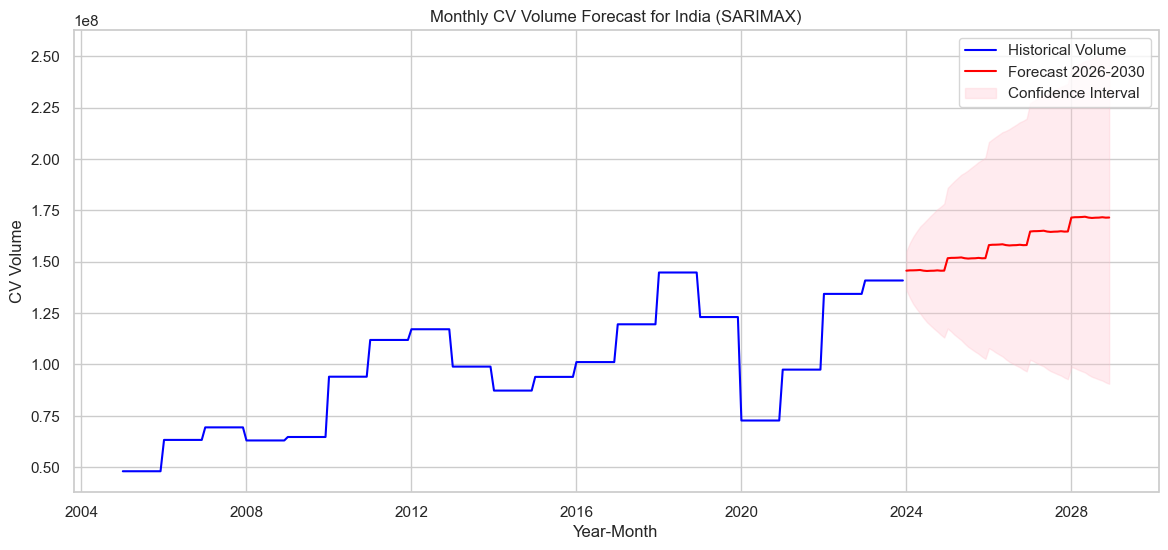

Forecast saved to 'India_monthly_cv_forecast_2026_2030.csv'
   Year-Month  Forecasted_Volume
0  2026-01-01       1.456731e+08
1  2026-02-01       1.458136e+08
2  2026-03-01       1.458297e+08
3  2026-04-01       1.458933e+08
4  2026-05-01       1.460044e+08
5  2026-06-01       1.456674e+08
6  2026-07-01       1.455193e+08
7  2026-08-01       1.456181e+08
8  2026-09-01       1.456551e+08
9  2026-10-01       1.458069e+08
10 2026-11-01       1.456446e+08
11 2026-12-01       1.456921e+08
12 2027-01-01       1.517364e+08
13 2027-02-01       1.518974e+08
14 2027-03-01       1.519159e+08
15 2027-04-01       1.519887e+08
16 2027-05-01       1.521159e+08
17 2027-06-01       1.517299e+08
18 2027-07-01       1.515603e+08
19 2027-08-01       1.516734e+08
20 2027-09-01       1.517158e+08
21 2027-10-01       1.518897e+08
22 2027-11-01       1.517038e+08
23 2027-12-01       1.517582e+08
24 2028-01-01       1.581240e+08
25 2028-02-01       1.582905e+08
26 2028-03-01       1.583095e+08
27 2028-04-01   

In [181]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Step 2: Load CSV
df = pd.read_csv('monthly_cv_with_macro.csv')

# Step 3: Filter for India
df_india = df[df['country'] == 'India'].copy()

# Step 4: Convert 'Year-Month' to datetime
df_india['Year-Month'] = pd.to_datetime(df_india['Year-Month'])

# Step 5: Aggregate duplicate months (sum volume, average macro)
df_india = df_india.groupby('Year-Month').agg({
    'volume': 'sum',
    'Diesel_USD_per_Liter': 'mean',
    'Petrol_USD_per_Liter': 'mean',
    'Monthly_GDP_USD': 'mean'
}).reset_index()

# Step 6: Sort by date
df_india = df_india.sort_values('Year-Month')

# Step 7: Set index and frequency
df_india.set_index('Year-Month', inplace=True)
df_india.index.freq = 'MS'  # monthly start

# Step 8: Handle missing values
df_india['volume'] = df_india['volume'].interpolate()  # linear interpolation for volume
for col in ['Diesel_USD_per_Liter', 'Petrol_USD_per_Liter', 'Monthly_GDP_USD']:
    df_india[col] = df_india[col].ffill()  # forward fill macro variables

# Step 9: Prepare target and exogenous variables
y = df_india['volume']
exog_cols = ['Diesel_USD_per_Liter', 'Petrol_USD_per_Liter', 'Monthly_GDP_USD']
exog = df_india[exog_cols]

# Step 10: Define SARIMAX model
model = SARIMAX(
    y,
    exog=exog,
    order=(1,1,0),               # ARIMA(p,d,q)
    seasonal_order=(1,0,0,12),   # Seasonal (P,D,Q,s)
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Step 11: Fit SARIMAX
model_fit = model.fit(disp=False)
print(model_fit.summary())

# Step 12: Forecast 2026–2030 (60 months)
future_index = pd.date_range(start='2026-01-01', end='2030-12-01', freq='MS')

# Generate future exogenous variables with growth assumptions
last_12_months = df_india[exog_cols].iloc[-12:].values
future_exog = []
for i in range(5):  # 5 years
    for j in range(12):  # 12 months
        diesel = last_12_months[j,0] * (1.02**(i+1))  # 2% annual growth
        petrol = last_12_months[j,1] * (1.02**(i+1))
        gdp = last_12_months[j,2] * (1.03**(i+1))     # 3% GDP growth
        future_exog.append([diesel, petrol, gdp])

future_exog = pd.DataFrame(future_exog, columns=exog_cols, index=future_index)

# Step 13: Get forecast
forecast = model_fit.get_forecast(steps=len(future_index), exog=future_exog)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Step 14: Plot historical + forecast
plt.figure(figsize=(14,6))
plt.plot(y.index, y.values, label='Historical Volume', color='blue')
plt.plot(forecast_mean.index, forecast_mean.values, label='Forecast 2026-2030', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('Monthly CV Volume Forecast for India (SARIMAX)')
plt.xlabel('Year-Month')
plt.ylabel('CV Volume')
plt.legend()
plt.grid(True)
plt.show()

# Step 15: Save forecast to CSV
forecast_df = pd.DataFrame({
    'Year-Month': future_index,
    'Forecasted_Volume': forecast_mean.values
})
forecast_df.to_csv('India_monthly_cv_forecast_2026_2030.csv', index=False)
print("Forecast saved to 'India_monthly_cv_forecast_2026_2030.csv'")

# Step 16: Optional: print forecast
print(forecast_df)


Processing Argentina...


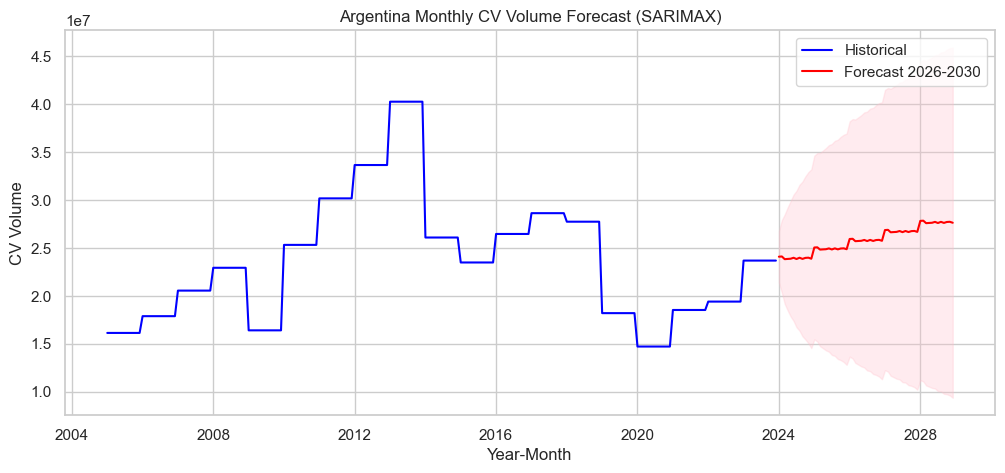

Processing Brazil...


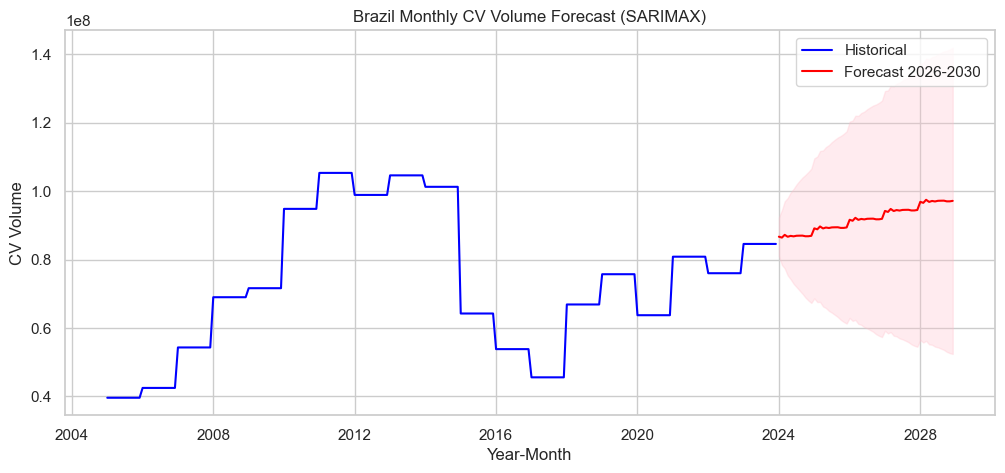

Processing India...


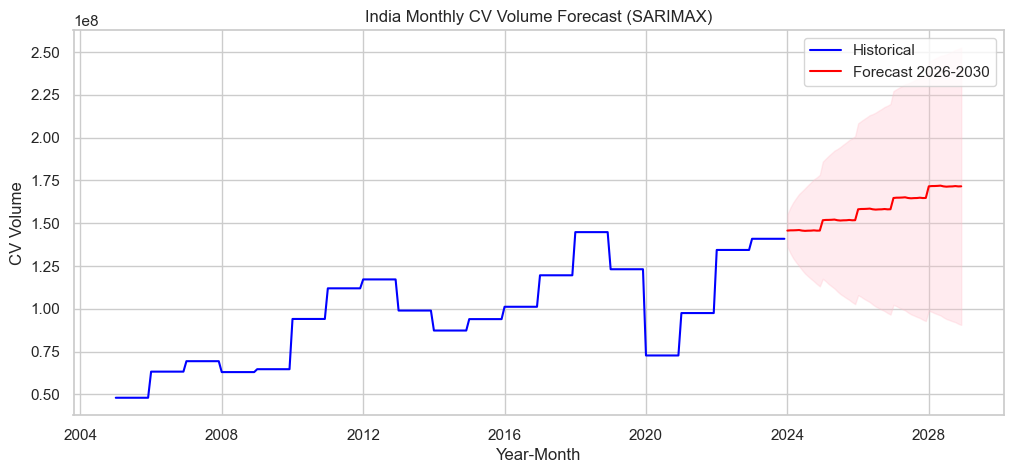

Processing Japan...


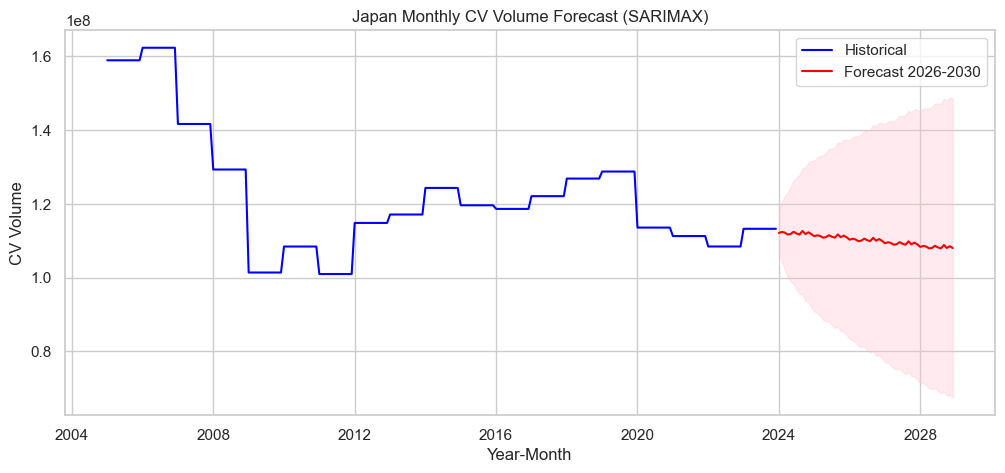

Processing Mexico...


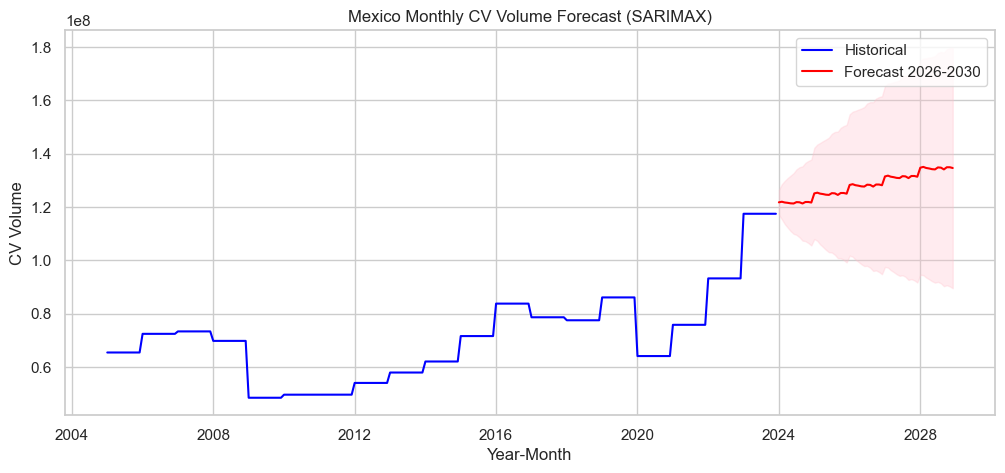

Processing South Africa...


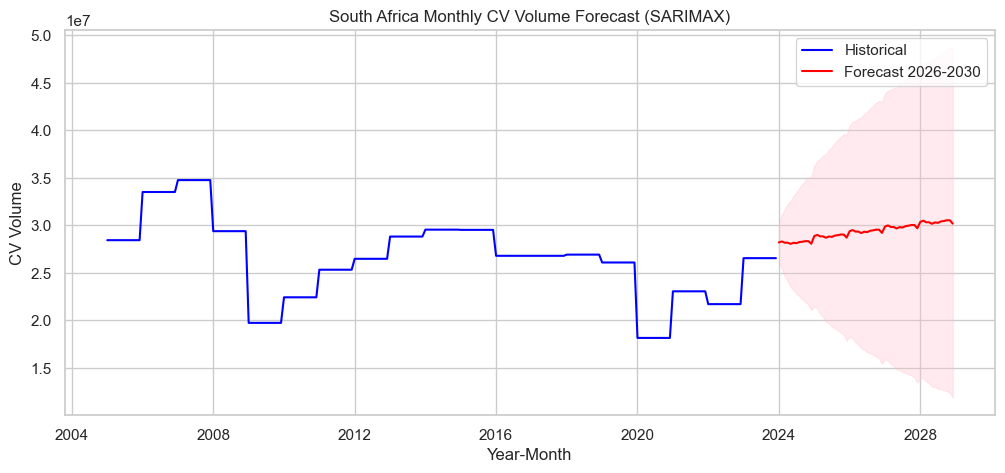

Processing Thailand...


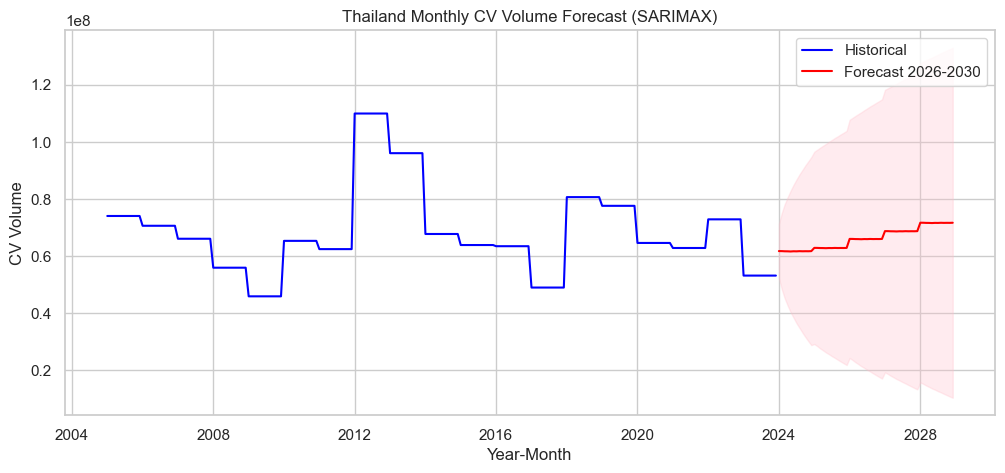

Processing United Arab Emirates...


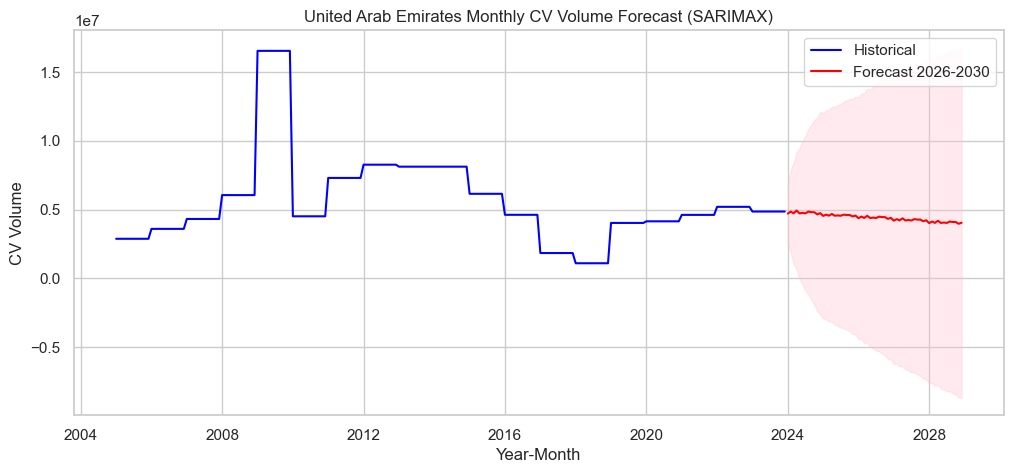

All country forecasts saved to 'All_Countries_Monthly_CV_Forecast_2026_2030.csv'


In [182]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Step 2: Load CSV
df = pd.read_csv('monthly_cv_with_macro.csv')

# Step 3: List of countries
countries = df['country'].unique()

# Step 4: Prepare empty DataFrame for all forecasts
all_forecasts = pd.DataFrame()

# Step 5: Loop through each country
for country in countries:
    print(f"Processing {country}...")

    # Filter for country
    df_country = df[df['country'] == country].copy()
    
    # Convert Year-Month to datetime
    df_country['Year-Month'] = pd.to_datetime(df_country['Year-Month'])
    
    # Aggregate duplicates
    df_country = df_country.groupby('Year-Month').agg({
        'volume': 'sum',
        'Diesel_USD_per_Liter': 'mean',
        'Petrol_USD_per_Liter': 'mean',
        'Monthly_GDP_USD': 'mean'
    }).reset_index()
    
    # Sort by date
    df_country = df_country.sort_values('Year-Month')
    
    # Set index and monthly frequency
    df_country.set_index('Year-Month', inplace=True)
    df_country.index.freq = 'MS'
    
    # Handle missing values
    df_country['volume'] = df_country['volume'].interpolate()
    for col in ['Diesel_USD_per_Liter', 'Petrol_USD_per_Liter', 'Monthly_GDP_USD']:
        df_country[col] = df_country[col].ffill()
    
    # Prepare target and exogenous variables
    y = df_country['volume']
    exog_cols = ['Diesel_USD_per_Liter', 'Petrol_USD_per_Liter', 'Monthly_GDP_USD']
    exog = df_country[exog_cols]
    
    # Fit SARIMAX
    model = SARIMAX(
        y,
        exog=exog,
        order=(1,1,0),
        seasonal_order=(1,0,0,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    model_fit = model.fit(disp=False)
    
    # Forecast 2026–2030
    future_index = pd.date_range(start='2026-01-01', end='2030-12-01', freq='MS')
    
    # Create future exog variables
    last_12_months = df_country[exog_cols].iloc[-12:].values
    future_exog = []
    for i in range(5):  # 5 years
        for j in range(12):
            diesel = last_12_months[j,0] * (1.02**(i+1))
            petrol = last_12_months[j,1] * (1.02**(i+1))
            gdp = last_12_months[j,2] * (1.03**(i+1))
            future_exog.append([diesel, petrol, gdp])
    future_exog = pd.DataFrame(future_exog, columns=exog_cols, index=future_index)
    
    # Generate forecast
    forecast = model_fit.get_forecast(steps=len(future_index), exog=future_exog)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    
    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'country': country,
        'Year-Month': future_index,
        'Forecasted_Volume': forecast_mean.values
    })
    
    # Append to all_forecasts
    all_forecasts = pd.concat([all_forecasts, forecast_df])
    
    # Plot historical + forecast
    plt.figure(figsize=(12,5))
    plt.plot(y.index, y.values, label='Historical', color='blue')
    plt.plot(forecast_mean.index, forecast_mean.values, label='Forecast 2026-2030', color='red')
    plt.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color='pink', alpha=0.3)
    plt.title(f'{country} Monthly CV Volume Forecast (SARIMAX)')
    plt.xlabel('Year-Month')
    plt.ylabel('CV Volume')
    plt.legend()
    plt.grid(True)
    plt.show()

# Step 6: Save all forecasts to CSV
all_forecasts.to_csv('All_Countries_Monthly_CV_Forecast_2026_2030.csv', index=False)
print("All country forecasts saved to 'All_Countries_Monthly_CV_Forecast_2026_2030.csv'")


# LD  AND HD  MAND MD

Processing Argentina...


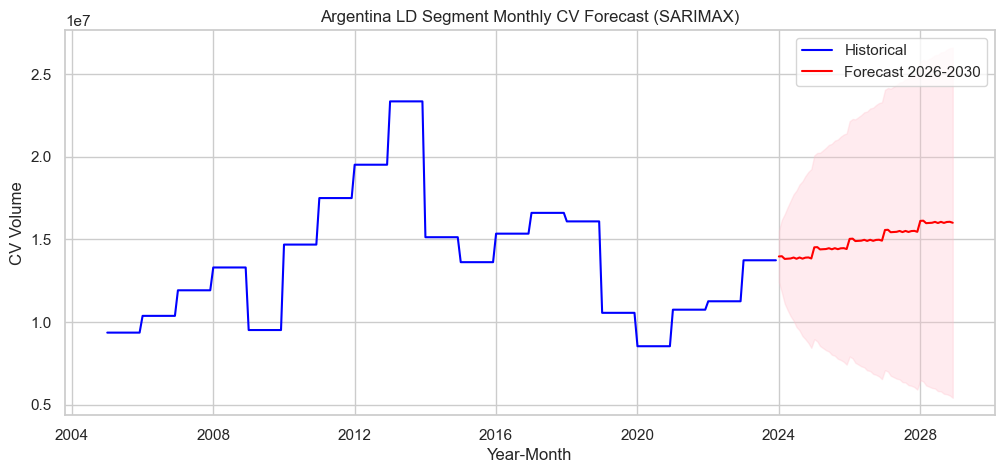

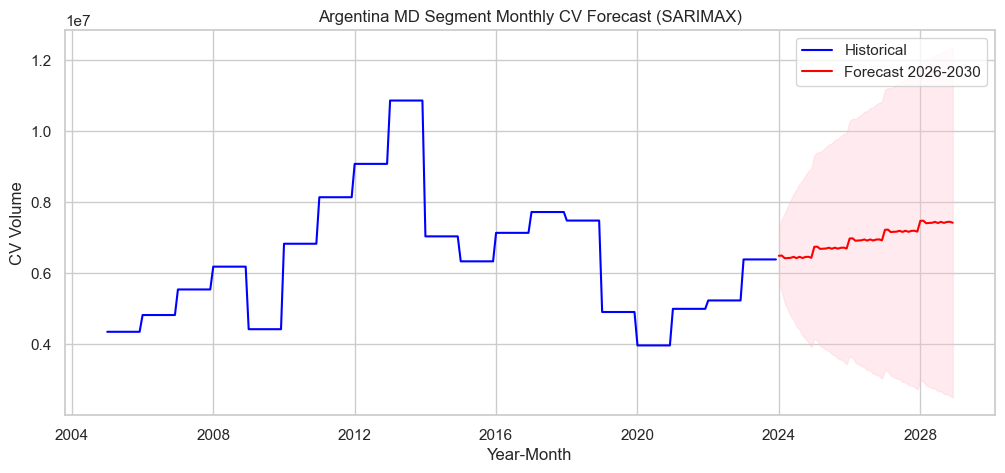

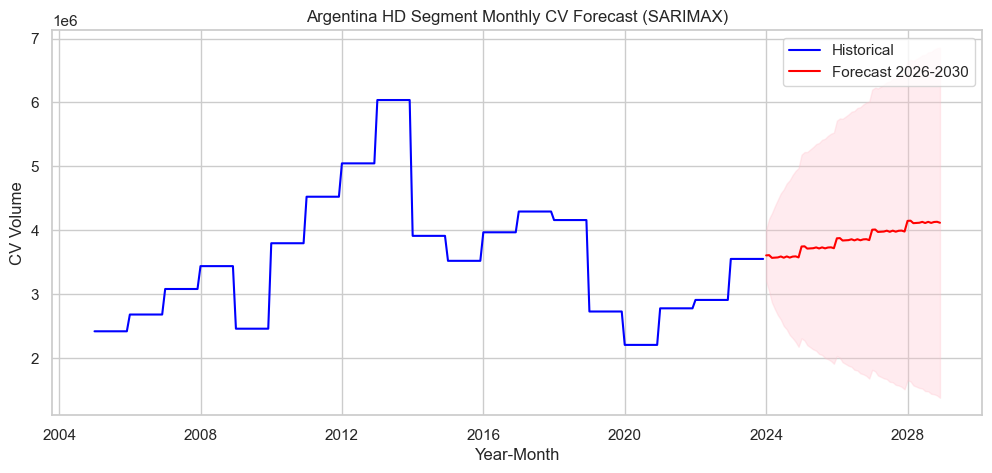

Processing Brazil...


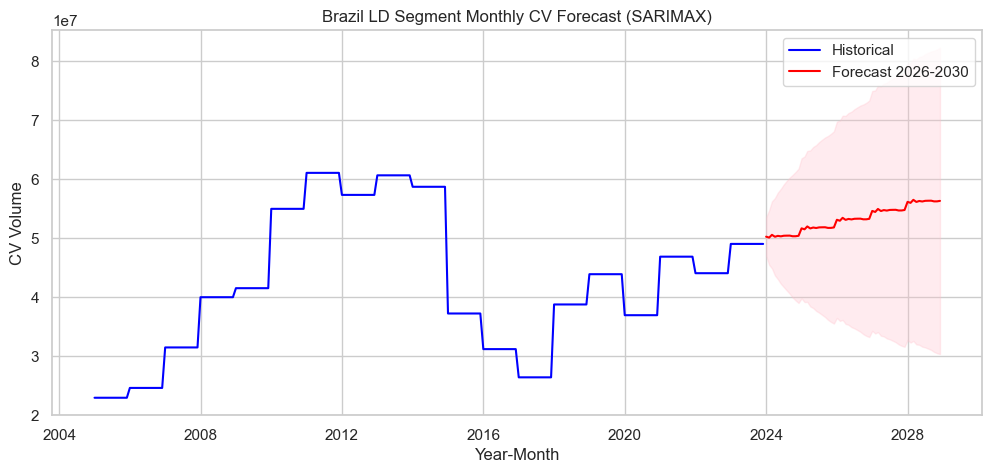

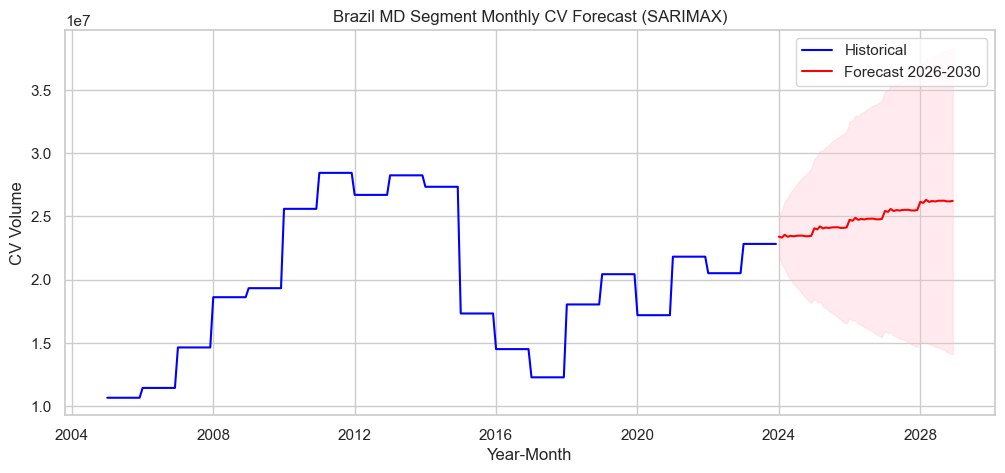

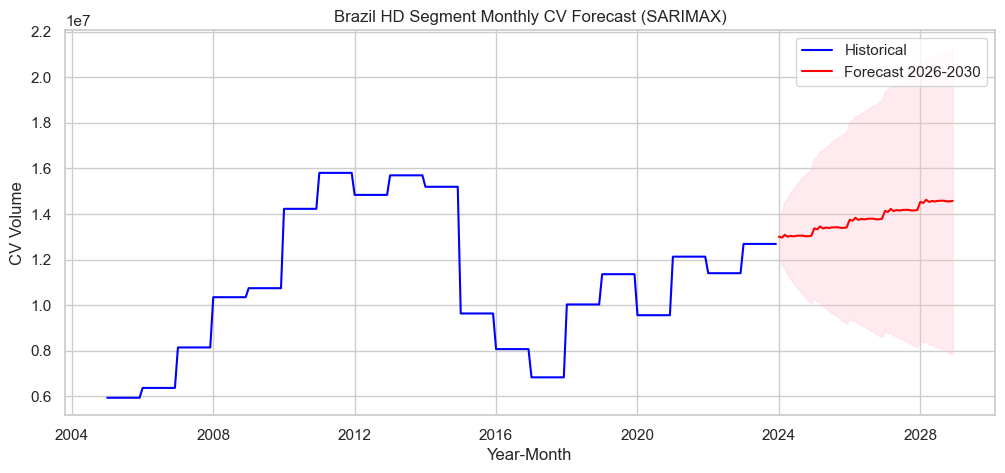

Processing India...


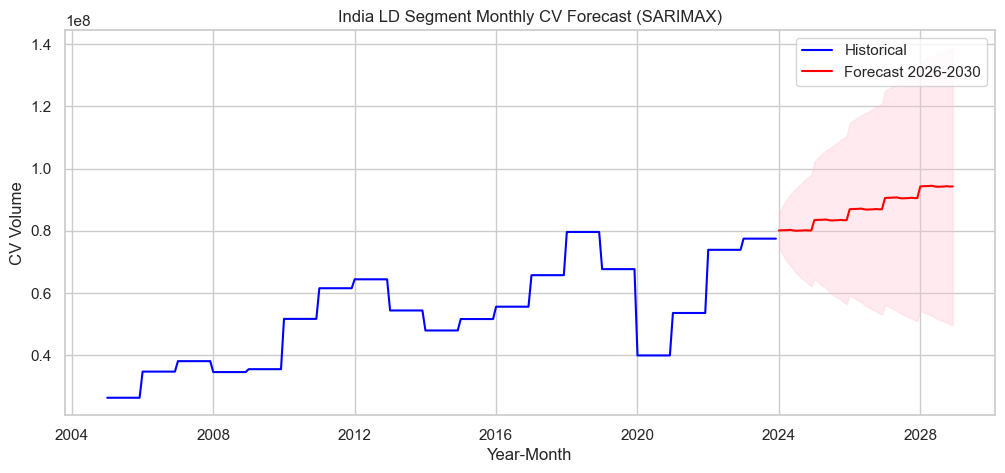

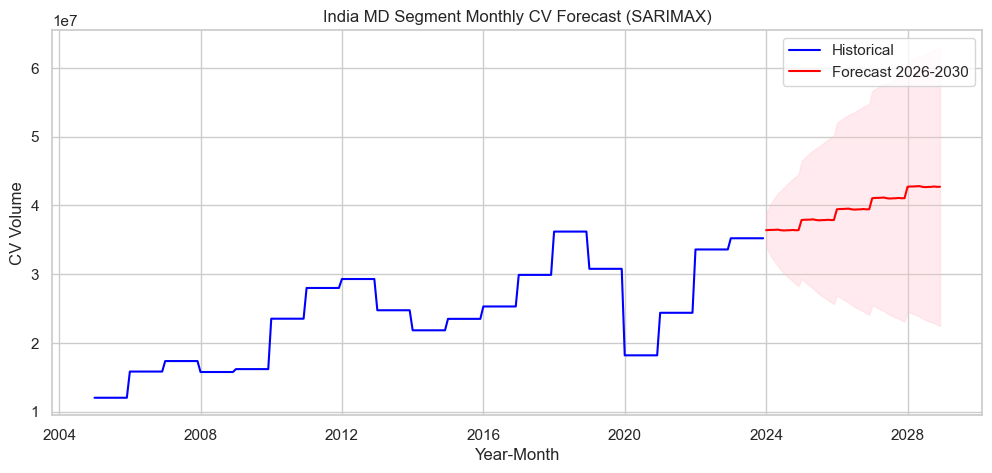

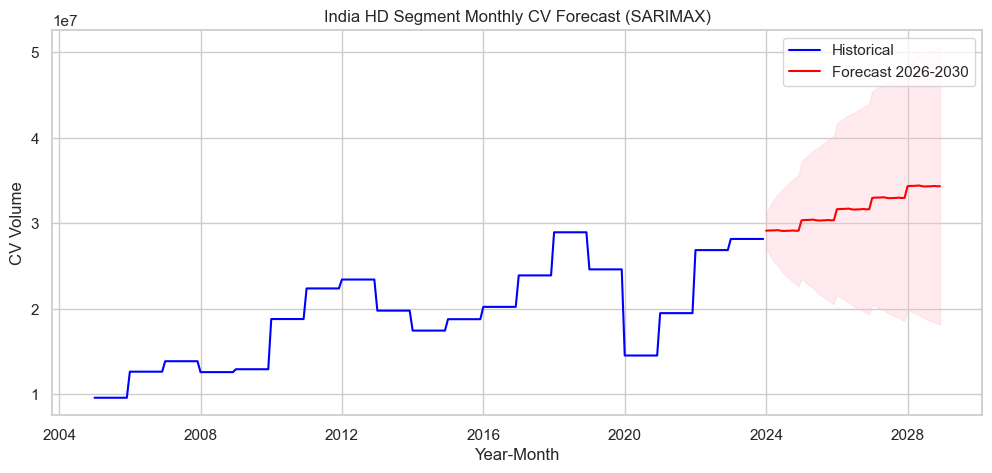

Processing Japan...


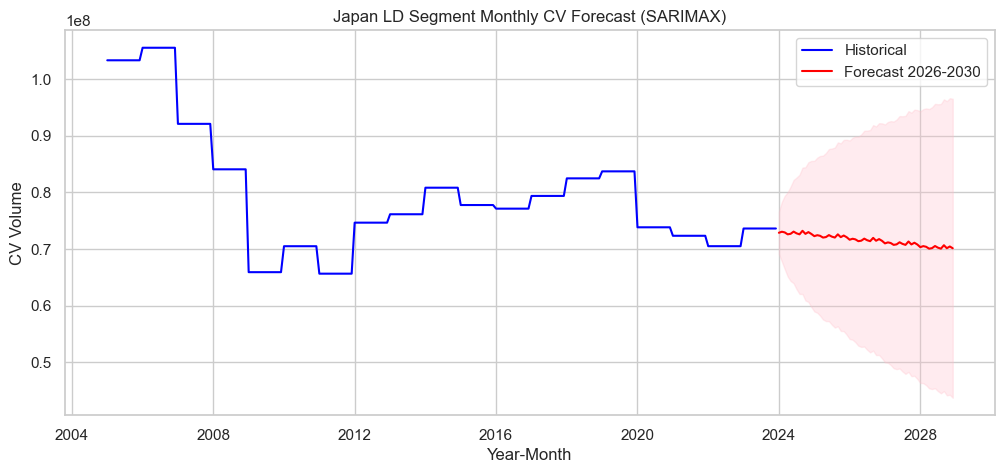

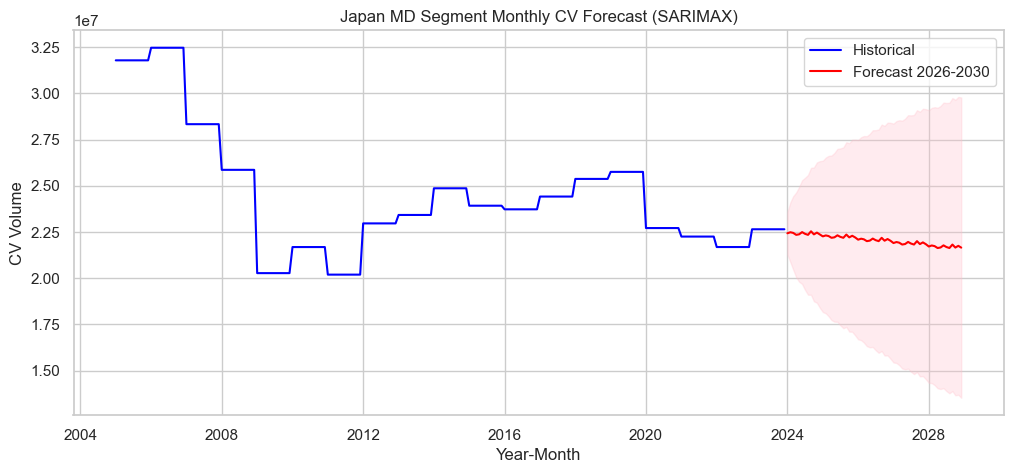

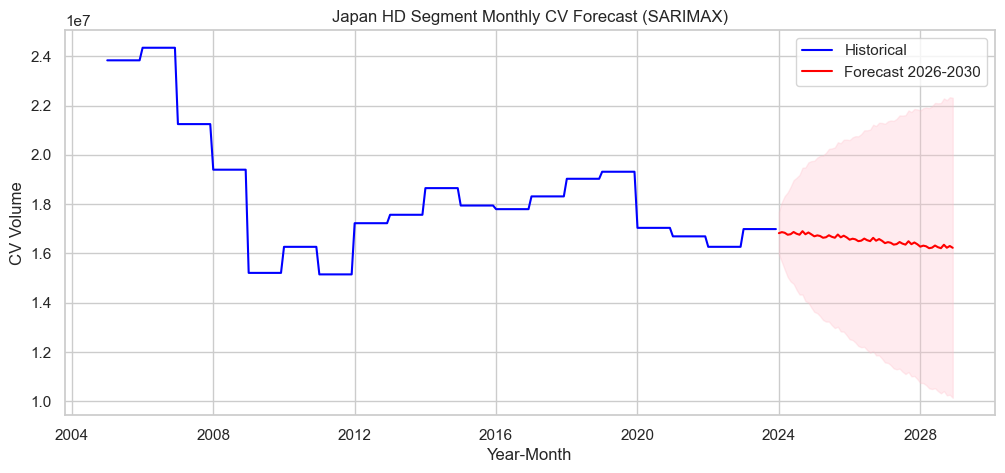

Processing Mexico...


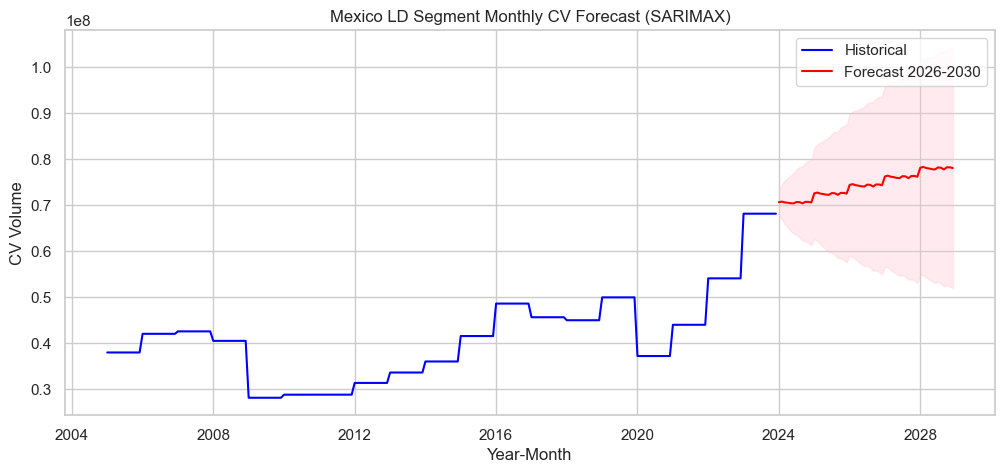

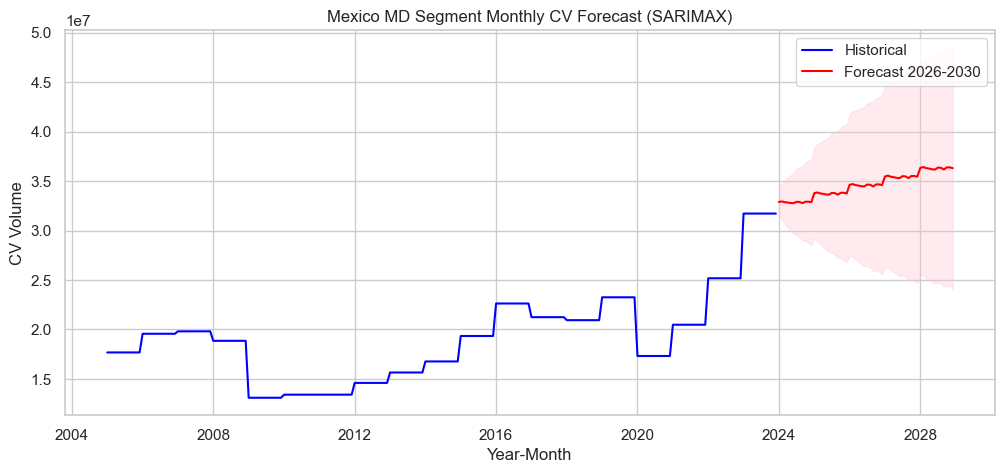

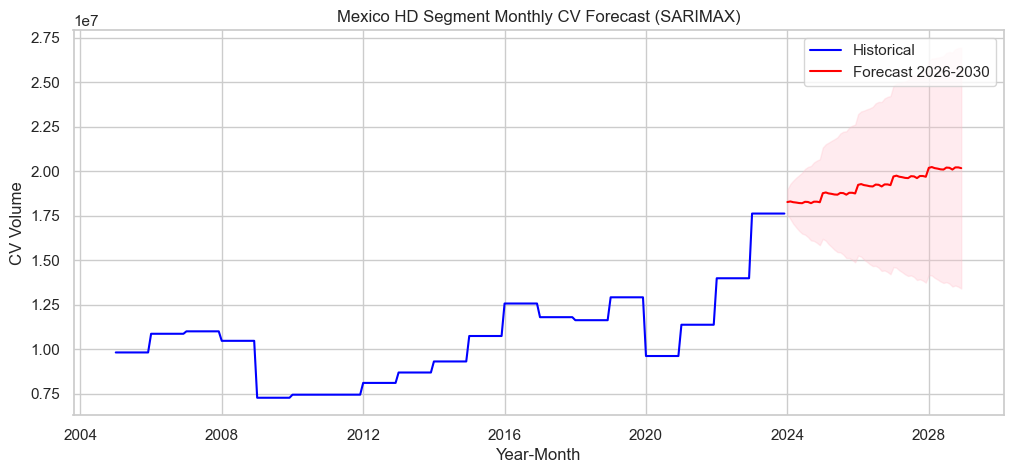

Processing South Africa...


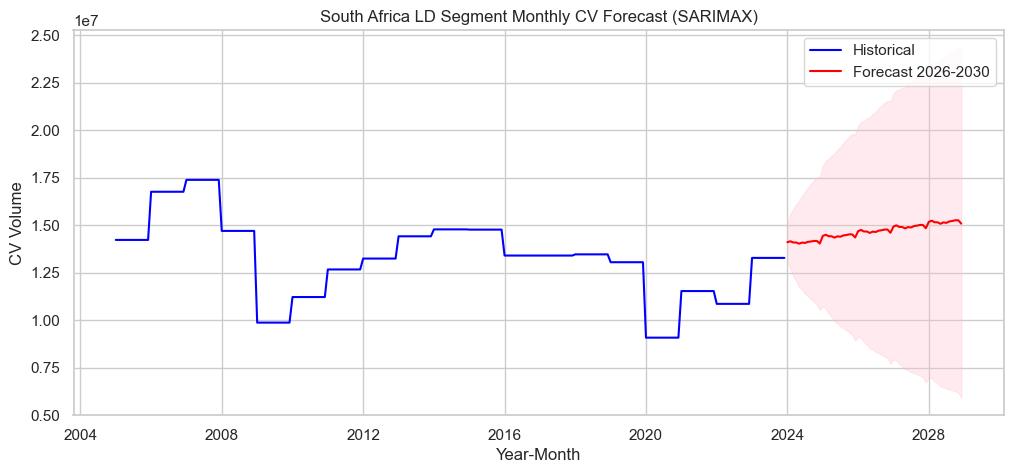

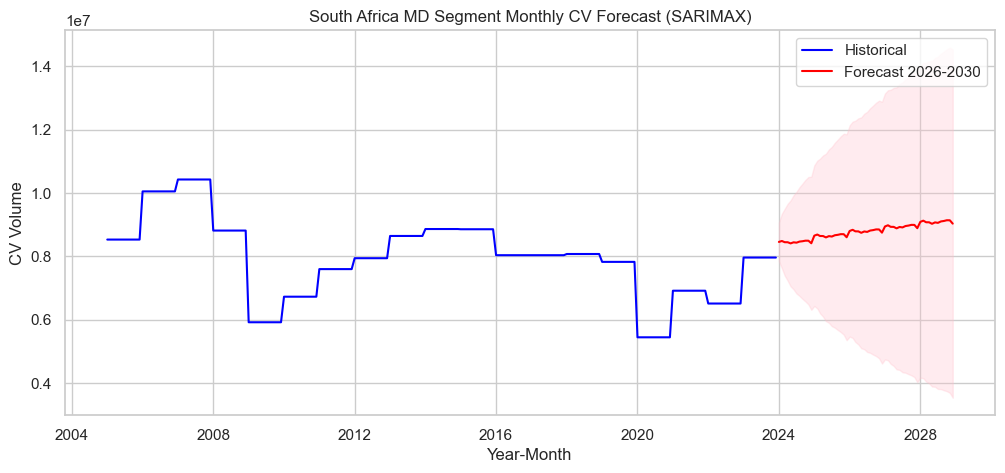

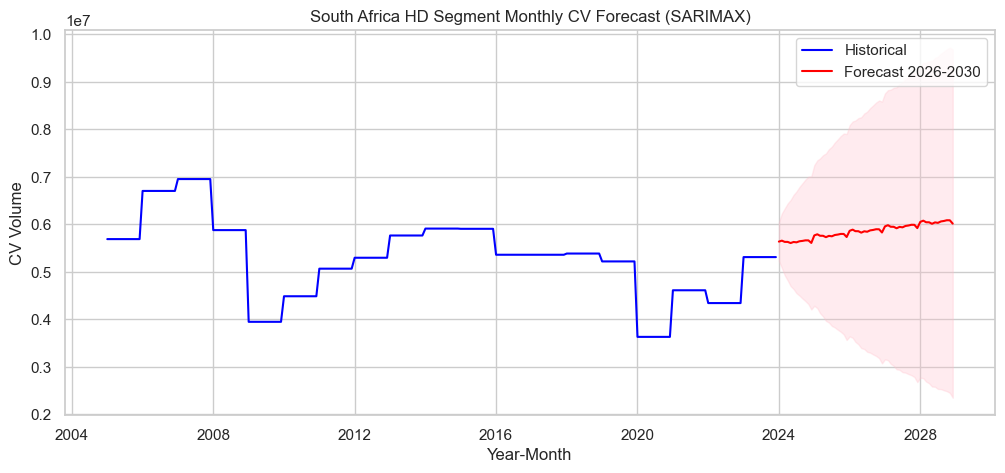

Processing Thailand...


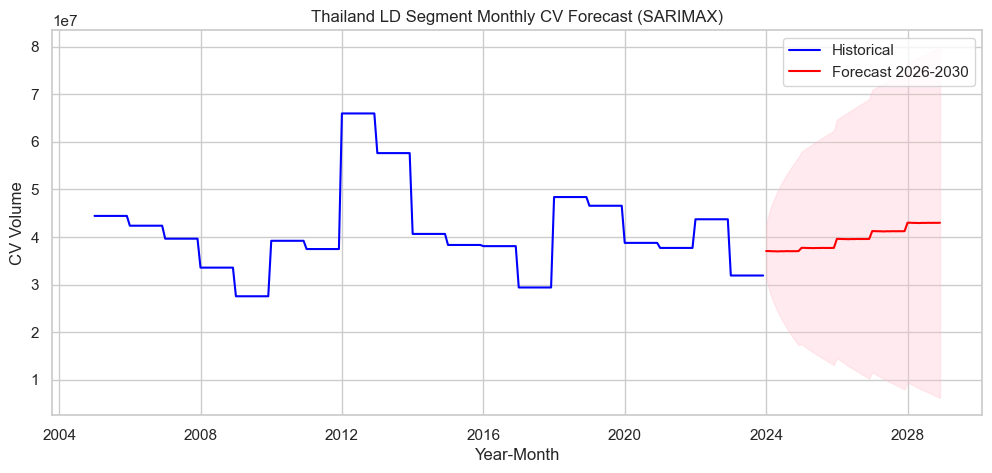

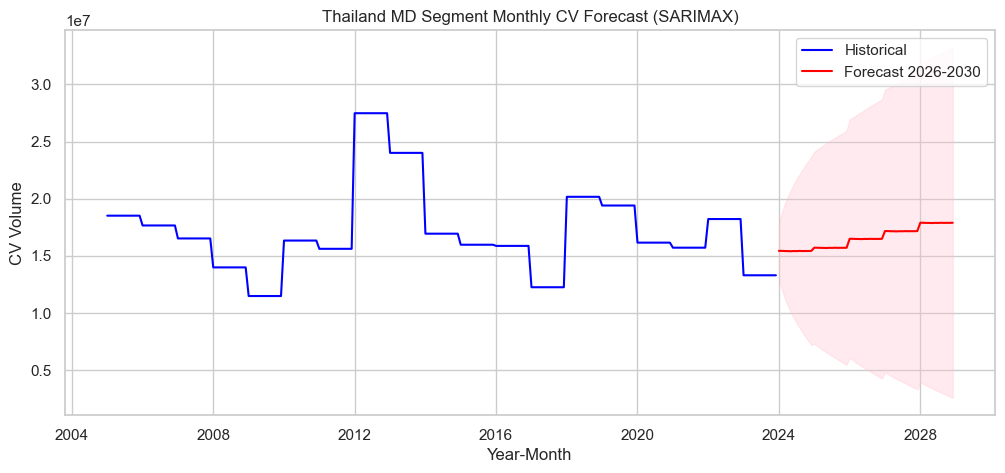

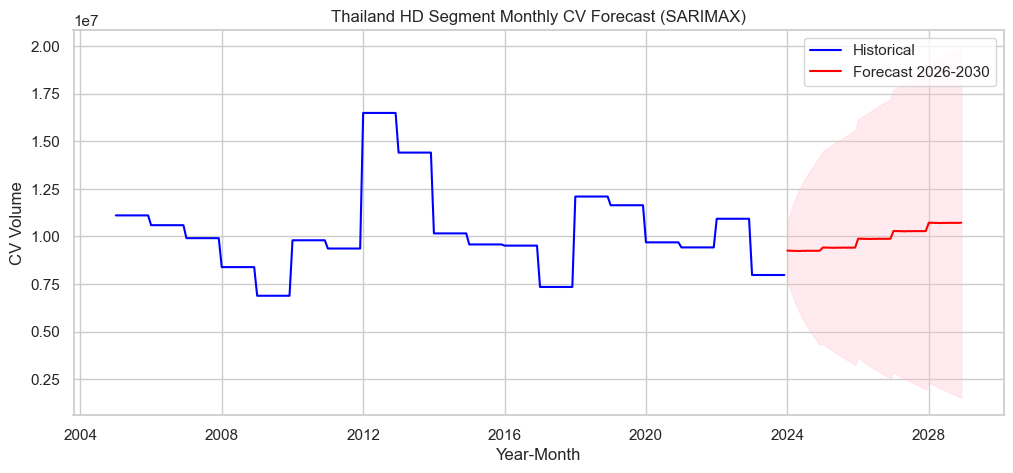

Processing United Arab Emirates...


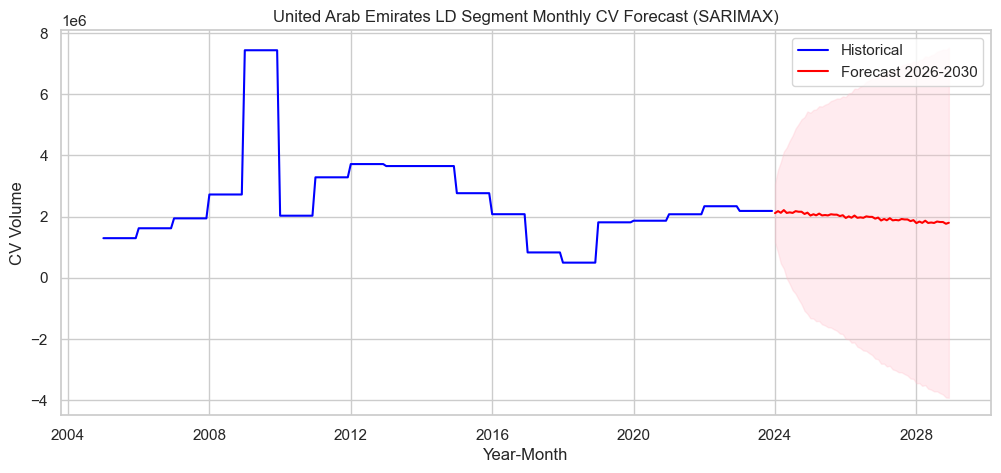

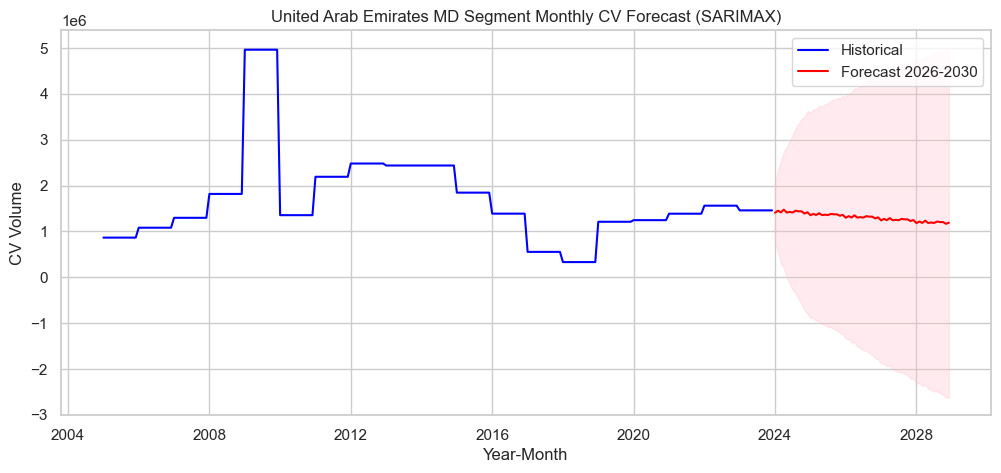

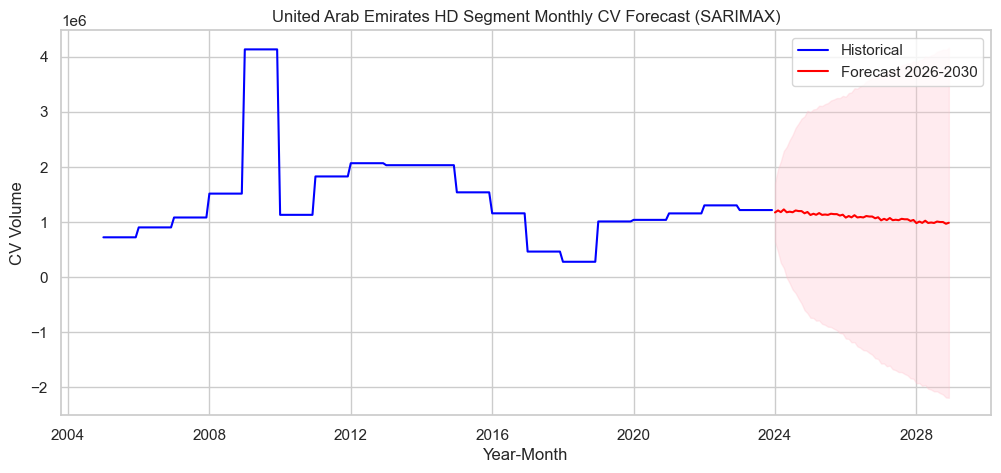

Forecast for LD, MD, HD segments saved to 'All_Countries_LD_MD_HD_CV_Forecast_2026_2030.csv'


In [183]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Step 2: Load CSV
df = pd.read_csv('monthly_cv_with_macro.csv')

# Step 3: List of countries and segments
countries = df['country'].unique()
segments = ['LD', 'MD', 'HD']

# Step 4: Prepare empty DataFrame for all forecasts
all_forecasts = pd.DataFrame()

# Step 5: Loop through each country and segment
for country in countries:
    print(f"Processing {country}...")
    df_country = df[df['country'] == country].copy()
    
    # Convert Year-Month to datetime
    df_country['Year-Month'] = pd.to_datetime(df_country['Year-Month'])
    
    # Loop through segments
    for seg in segments:
        # Aggregate duplicates for this segment
        df_seg = df_country.groupby('Year-Month').agg({
            seg: 'sum',
            'Diesel_USD_per_Liter': 'mean',
            'Petrol_USD_per_Liter': 'mean',
            'Monthly_GDP_USD': 'mean'
        }).reset_index()
        
        # Sort and set index
        df_seg = df_seg.sort_values('Year-Month')
        df_seg.set_index('Year-Month', inplace=True)
        df_seg.index.freq = 'MS'
        
        # Handle missing values
        df_seg[seg] = df_seg[seg].interpolate()
        for col in ['Diesel_USD_per_Liter', 'Petrol_USD_per_Liter', 'Monthly_GDP_USD']:
            df_seg[col] = df_seg[col].ffill()
        
        # Prepare target and exogenous
        y = df_seg[seg]
        exog_cols = ['Diesel_USD_per_Liter', 'Petrol_USD_per_Liter', 'Monthly_GDP_USD']
        exog = df_seg[exog_cols]
        
        # Fit SARIMAX
        model = SARIMAX(
            y,
            exog=exog,
            order=(1,1,0),
            seasonal_order=(1,0,0,12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False)
        
        # Forecast 2026–2030
        future_index = pd.date_range(start='2026-01-01', end='2030-12-01', freq='MS')
        last_12_months = df_seg[exog_cols].iloc[-12:].values
        future_exog = []
        for i in range(5):  # 5 years
            for j in range(12):  # 12 months
                diesel = last_12_months[j,0] * (1.02**(i+1))
                petrol = last_12_months[j,1] * (1.02**(i+1))
                gdp = last_12_months[j,2] * (1.03**(i+1))
                future_exog.append([diesel, petrol, gdp])
        future_exog = pd.DataFrame(future_exog, columns=exog_cols, index=future_index)
        
        forecast = model_fit.get_forecast(steps=len(future_index), exog=future_exog)
        forecast_mean = forecast.predicted_mean
        forecast_ci = forecast.conf_int()
        
        # Prepare forecast DataFrame
        forecast_df = pd.DataFrame({
            'country': country,
            'segment': seg,
            'Year-Month': future_index,
            'Forecasted_Volume': forecast_mean.values
        })
        
        # Append to all_forecasts
        all_forecasts = pd.concat([all_forecasts, forecast_df])
        
        # Plot for each segment
        plt.figure(figsize=(12,5))
        plt.plot(y.index, y.values, label='Historical', color='blue')
        plt.plot(forecast_mean.index, forecast_mean.values, label='Forecast 2026-2030', color='red')
        plt.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color='pink', alpha=0.3)
        plt.title(f'{country} {seg} Segment Monthly CV Forecast (SARIMAX)')
        plt.xlabel('Year-Month')
        plt.ylabel('CV Volume')
        plt.legend()
        plt.grid(True)
        plt.show()

# Step 6: Save all forecasts to CSV
all_forecasts.to_csv('All_Countries_LD_MD_HD_CV_Forecast_2026_2030.csv', index=False)
print("Forecast for LD, MD, HD segments saved to 'All_Countries_LD_MD_HD_CV_Forecast_2026_2030.csv'")


In [184]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Load dataset
df = pd.read_csv('monthly_cv_with_macro.csv')

# Macro growth assumptions
diesel_growth = 0.01
petrol_growth = 0.01
gdp_growth = 0.02
forecast_years = range(2026, 2031)

all_countries_forecast = []

for country in df['country'].unique():
    df_country = df[df['country']==country].copy()
    
    # Fill missing values
    for col in ['LD','MD','HD','Diesel_USD_per_Liter','Petrol_USD_per_Liter','Monthly_GDP_USD']:
        df_country[col] = df_country[col].interpolate().ffill()
    
    df_country['Total'] = df_country['LD'] + df_country['MD'] + df_country['HD']
    
    # Average of last 6 months for features
    last_6 = df_country[['LD','MD','HD','Total','Diesel_USD_per_Liter','Petrol_USD_per_Liter','Monthly_GDP_USD']].iloc[-6:].mean()
    
    # Yearly aggregated historical data for training
    df_country['Year'] = pd.to_datetime(df_country['Year-Month']).dt.year
    yearly_data = df_country.groupby('Year')[['LD','MD','HD','Total','Diesel_USD_per_Liter','Petrol_USD_per_Liter','Monthly_GDP_USD']].mean().reset_index()
    
    X_train = yearly_data[['LD','MD','HD','Total','Diesel_USD_per_Liter','Petrol_USD_per_Liter','Monthly_GDP_USD']]
    y_train = yearly_data[['LD','MD','HD']]
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Forecast future years
    for y in forecast_years:
        diesel = last_6['Diesel_USD_per_Liter'] * (1 + diesel_growth) ** (y - 2025)
        petrol = last_6['Petrol_USD_per_Liter'] * (1 + petrol_growth) ** (y - 2025)
        gdp = last_6['Monthly_GDP_USD'] * (1 + gdp_growth) ** (y - 2025)
        
        # Use DataFrame with column names to avoid sklearn warning
        X_pred = pd.DataFrame([[last_6['LD'], last_6['MD'], last_6['HD'], last_6['Total'], diesel, petrol, gdp]],
                              columns=X_train.columns)
        pred = rf.predict(X_pred)[0]
        total = sum(pred)
        
        all_countries_forecast.append([country, y, int(round(pred[0])), int(round(pred[1])), int(round(pred[2])), int(round(total))])

# Create final DataFrame
forecast_df = pd.DataFrame(all_countries_forecast, columns=['Country','Year','LD','MD','HD','Total'])
print(forecast_df)

# Save to CSV
forecast_df.to_csv('RF_Countrywise_Yearly_Forecast_2026_2030.csv', index=False)
print("Forecast saved to 'RF_Countrywise_Yearly_Forecast_2026_2030.csv'")


                 Country  Year     LD     MD     HD  Total
0              Argentina  2026   8085   3764   2091  13940
1              Argentina  2027   8085   3764   2091  13940
2              Argentina  2028   8085   3764   2091  13940
3              Argentina  2029   8085   3764   2091  13940
4              Argentina  2030   8085   3764   2091  13940
5                 Brazil  2026  27947  13010   7228  48185
6                 Brazil  2027  27947  13010   7228  48185
7                 Brazil  2028  28309  13178   7321  48809
8                 Brazil  2029  28824  13418   7455  49697
9                 Brazil  2030  28824  13418   7455  49697
10                 India  2026  42783  19447  15557  77787
11                 India  2027  43446  19748  15799  78993
12                 India  2028  43333  19697  15758  78788
13                 India  2029  43333  19697  15758  78788
14                 India  2030  43333  19697  15758  78788
15                 Japan  2026  40782  12548   9411  627

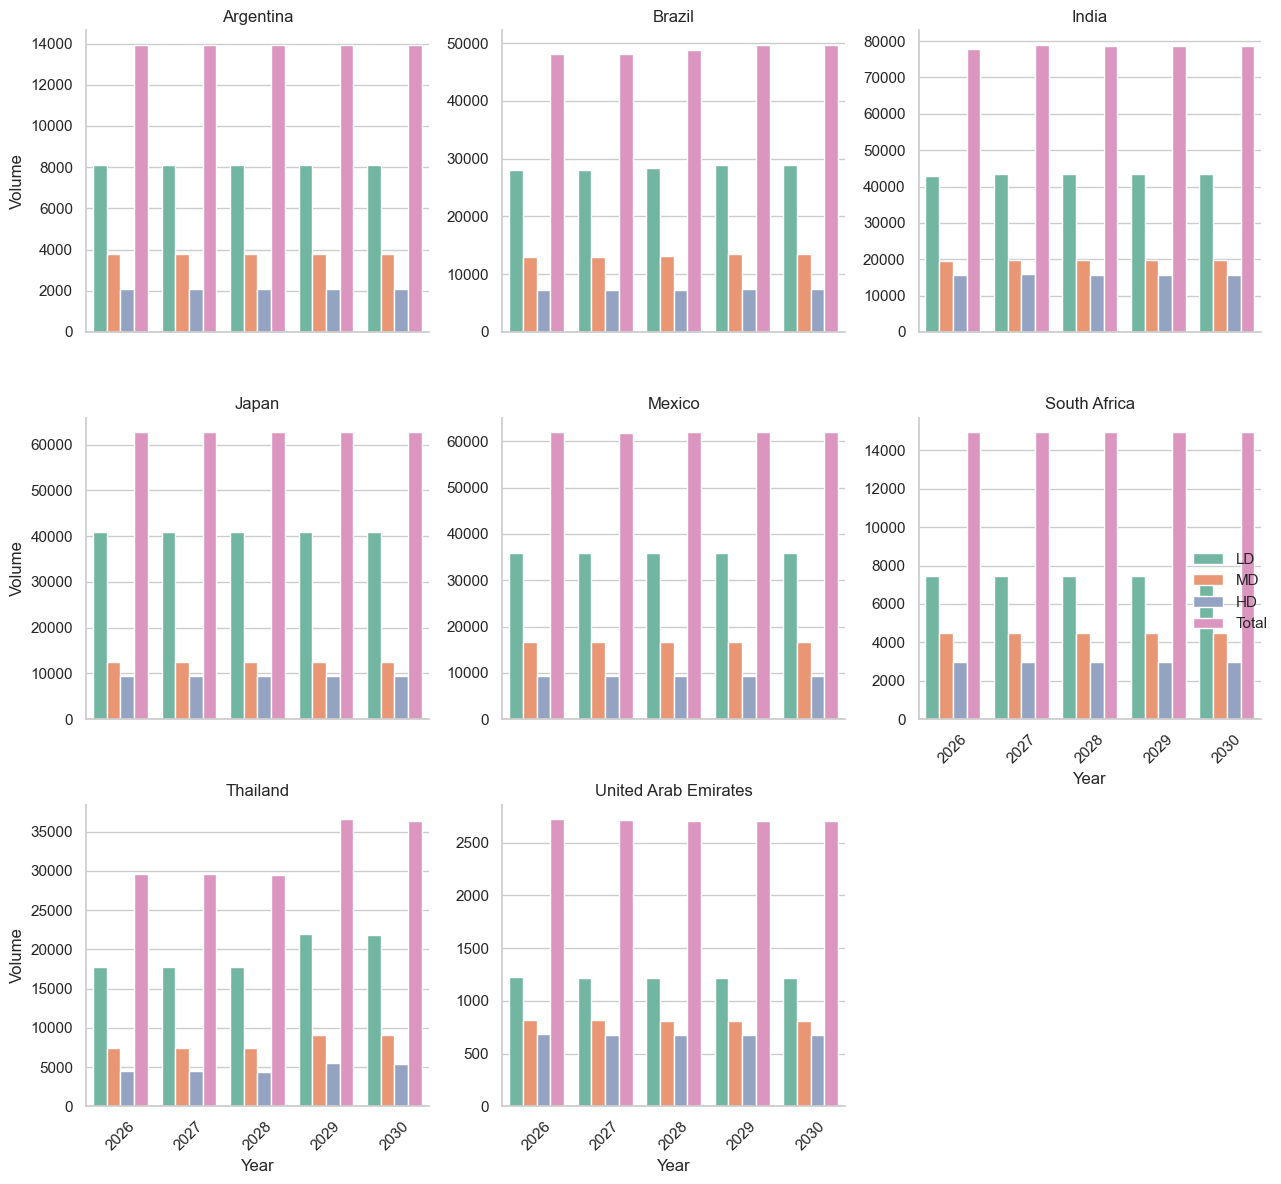

In [185]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load forecast CSV
forecast_df = pd.read_csv('RF_Countrywise_Yearly_Forecast_2026_2030.csv')

# Ensure numeric
for col in ['LD','MD','HD','Total']:
    forecast_df[col] = pd.to_numeric(forecast_df[col])

# Melt dataframe for seaborn plotting (long format)
df_melt = forecast_df.melt(id_vars=['Country','Year'], 
                           value_vars=['LD','MD','HD','Total'],
                           var_name='Segment', value_name='Volume')

# Set style
sns.set(style="whitegrid")

# Create FacetGrid: one subplot per country
g = sns.FacetGrid(df_melt, col="Country", col_wrap=3, height=4, sharey=False)
g.map_dataframe(sns.barplot, x='Year', y='Volume', hue='Segment', palette='Set2', ci=None)
g.add_legend()
g.set_titles("{col_name}")
g.set_axis_labels("Year", "Volume")

# Rotate x-axis labels for readability
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()


# Model evaluation and performacne 

In [189]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# ==========================================================
# UNIVERSAL FORECAST EVALUATION FUNCTION
# ==========================================================

def evaluate_model(y_true, y_pred, model_name="Model", n_features=None):
    
    y_true = pd.Series(y_true).reset_index(drop=True)
    y_pred = pd.Series(y_pred).reset_index(drop=True)

    mask = ~(y_true.isna() | y_pred.isna())
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    n = len(y_true)

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    bias = np.mean(y_pred - y_true)

    non_zero = y_true != 0
    mape = np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

    smape = np.mean(
        2 * np.abs(y_pred - y_true) /
        (np.abs(y_true) + np.abs(y_pred))
    ) * 100

    r2 = r2_score(y_true, y_pred)

    if n_features is not None and n > n_features + 1:
        adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - n_features - 1))
    else:
        adj_r2 = np.nan

    return {
        "Model": model_name,
        "MAE": mae,
        "RMSE": rmse,
        "MSE": mse,
        "MAPE(%)": mape,
        "SMAPE(%)": smape,
        "R2": r2,
        "Adj_R2": adj_r2,
        "Bias": bias
    }


# ==========================================================
# EXAMPLE USAGE
# ==========================================================

y_true = [100, 120, 130, 150, 170]
y_pred1 = [110, 115, 128, 160, 165]
y_pred2 = [108, 118, 132, 155, 168]

model1 = evaluate_model(y_true, y_pred1, "SARIMAX", 2)
model2 = evaluate_model(y_true, y_pred2, "LinearReg", 2)

final_results = pd.DataFrame([model1, model2])
final_results = final_results.sort_values(by="RMSE")

# ==========================================================
# PRINT IN SINGLE LINE FORMAT (COMPACT & ALIGNED)
# ==========================================================

print("\n📊 MODEL PERFORMANCE SUMMARY\n")

print(f"{'Model':<12} {'MAE':>8} {'RMSE':>8} {'MSE':>10} "
      f"{'MAPE%':>8} {'SMAPE%':>8} {'R2':>8} {'AdjR2':>8} {'Bias':>8}")

print("-" * 85)

for _, row in final_results.iterrows():
    print(f"{row['Model']:<12} "
          f"{row['MAE']:>8.2f} "
          f"{row['RMSE']:>8.2f} "
          f"{row['MSE']:>10.2f} "
          f"{row['MAPE(%)']:>8.2f} "
          f"{row['SMAPE(%)']:>8.2f} "
          f"{row['R2']:>8.4f} "
          f"{row['Adj_R2']:>8.4f} "
          f"{row['Bias']:>8.2f}")



📊 MODEL PERFORMANCE SUMMARY

Model             MAE     RMSE        MSE    MAPE%   SMAPE%       R2    AdjR2     Bias
-------------------------------------------------------------------------------------
LinearReg        3.80     4.49      20.20     3.14     3.07   0.9654   0.9308     2.20
SARIMAX          6.40     7.13      50.80     5.06     4.95   0.9130   0.8260     1.60


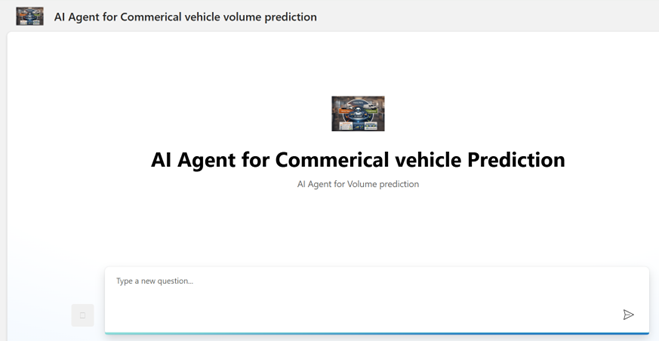

# AI Agent

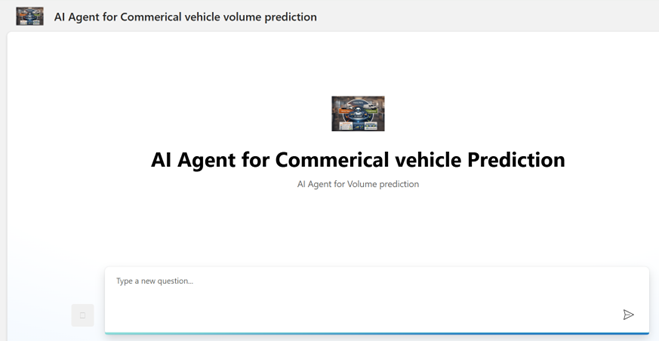

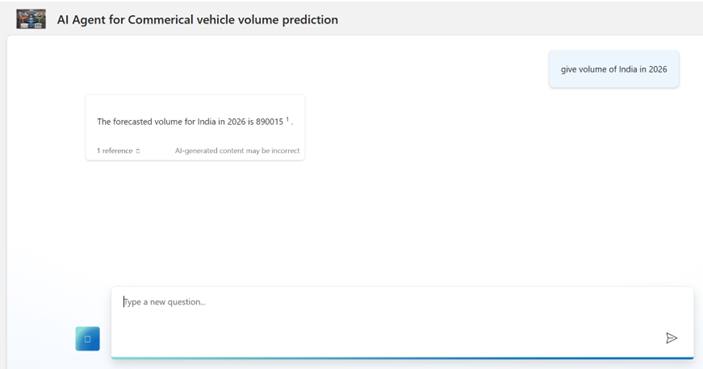